In [1]:
import json
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from zipfile import ZipFile
import shutil
import time
from tqdm import tqdm  
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
import pyspark

# ISTANBUL ÇALIŞMASI

In [2]:
istanbul = pd.read_csv("türkiye/türkiye_monthly.csv")
istanbul = istanbul.drop(columns=("index"))
istanbul = istanbul.drop(columns=("Unnamed: 0"))
istanbul = istanbul.loc[istanbul.city == "İstanbul"]
istanbul.reset_index(drop=True, inplace=True)

In [3]:
istanbul

,time,tavg,tmin,tmax,prcp,wspd,pres,tsun,city,country
0,1929-01-01,NaN,1.7,9.2,NaN,NaN,NaN,NaN,İstanbul,Türkiye
1,1929-02-01,NaN,-0.9,4.8,NaN,NaN,NaN,NaN,İstanbul,Türkiye
2,1929-03-01,NaN,0.0,6.9,NaN,NaN,NaN,NaN,İstanbul,Türkiye
3,1929-04-01,NaN,4.8,15.1,NaN,NaN,NaN,NaN,İstanbul,Türkiye
4,1929-05-01,NaN,13.3,24.4,NaN,NaN,NaN,NaN,İstanbul,Türkiye
...,...,...,...,...,...,...,...,...,...,...
1130,2023-03-01,8.9,5.7,13.1,97.1,15.6,1014.2,NaN,İstanbul,Türkiye
1131,2023-04-01,11.7,8.4,15.9,98.7,14.0,1012.0,NaN,İstanbul,Türkiye
1132,2023-05-01,14.9,11.6,19.3,76.4,15.6,1015.1,NaN,İstanbul,Türkiye
1133,2023-06-01,20.2,16.3,25.0,46.6,15.3,1012.6,NaN,İstanbul,Türkiye


In [4]:
istanbul.dropna(thresh=1, inplace=True)
istanbul

,time,tavg,tmin,tmax,prcp,wspd,pres,tsun,city,country
0,1929-01-01,NaN,1.7,9.2,NaN,NaN,NaN,NaN,İstanbul,Türkiye
1,1929-02-01,NaN,-0.9,4.8,NaN,NaN,NaN,NaN,İstanbul,Türkiye
2,1929-03-01,NaN,0.0,6.9,NaN,NaN,NaN,NaN,İstanbul,Türkiye
3,1929-04-01,NaN,4.8,15.1,NaN,NaN,NaN,NaN,İstanbul,Türkiye
4,1929-05-01,NaN,13.3,24.4,NaN,NaN,NaN,NaN,İstanbul,Türkiye
...,...,...,...,...,...,...,...,...,...,...
1130,2023-03-01,8.9,5.7,13.1,97.1,15.6,1014.2,NaN,İstanbul,Türkiye
1131,2023-04-01,11.7,8.4,15.9,98.7,14.0,1012.0,NaN,İstanbul,Türkiye
1132,2023-05-01,14.9,11.6,19.3,76.4,15.6,1015.1,NaN,İstanbul,Türkiye
1133,2023-06-01,20.2,16.3,25.0,46.6,15.3,1012.6,NaN,İstanbul,Türkiye


In [5]:
#boş avgları dolduruyorum
istanbul.loc[pd.isna(istanbul["tavg"]), "tavg"] = (istanbul["tmax"] + istanbul["tmin"]) / 2

In [6]:
istanbul

,time,tavg,tmin,tmax,prcp,wspd,pres,tsun,city,country
0,1929-01-01,5.45,1.7,9.2,NaN,NaN,NaN,NaN,İstanbul,Türkiye
1,1929-02-01,1.95,-0.9,4.8,NaN,NaN,NaN,NaN,İstanbul,Türkiye
2,1929-03-01,3.45,0.0,6.9,NaN,NaN,NaN,NaN,İstanbul,Türkiye
3,1929-04-01,9.95,4.8,15.1,NaN,NaN,NaN,NaN,İstanbul,Türkiye
4,1929-05-01,18.85,13.3,24.4,NaN,NaN,NaN,NaN,İstanbul,Türkiye
...,...,...,...,...,...,...,...,...,...,...
1130,2023-03-01,8.90,5.7,13.1,97.1,15.6,1014.2,NaN,İstanbul,Türkiye
1131,2023-04-01,11.70,8.4,15.9,98.7,14.0,1012.0,NaN,İstanbul,Türkiye
1132,2023-05-01,14.90,11.6,19.3,76.4,15.6,1015.1,NaN,İstanbul,Türkiye
1133,2023-06-01,20.20,16.3,25.0,46.6,15.3,1012.6,NaN,İstanbul,Türkiye


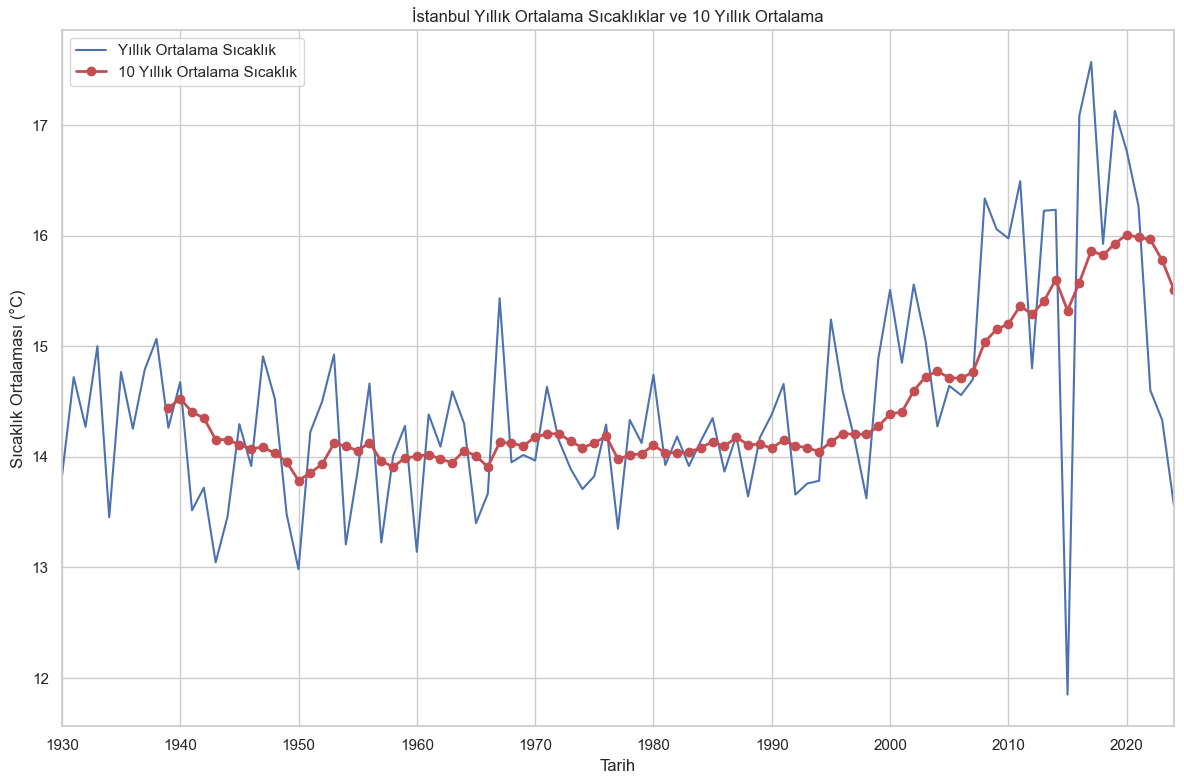

In [7]:
# Tarih sütununu datetime formatına çeviriyoruz
istanbul['time'] = pd.to_datetime(istanbul['time'])

# yıllık ortalama sıcaklıkları çekiyorum
istanbul_ortalama = istanbul.copy()
istanbul_ortalama.set_index("time", inplace=True)

# Yıllık ortalama sıcaklık hesaplaması
istanbul_ortalama = istanbul_ortalama.resample("Y").mean()

# Yıllık ortalama sıcaklık verilerini ayrı bir DataFrame olarak kaydetme
istanbul_ortalama = pd.DataFrame(istanbul_ortalama, columns=["tavg"])
istanbul_ortalama.reset_index(drop=False, inplace=True)

# 10 yıllık hareketli ortalamaları al
ten_year_avg = istanbul_ortalama["tavg"].rolling(window=10).mean()

# Grafiğin boyutunu ayarlayın
plt.figure(figsize=(12, 8))

# Arka planı beyaz yerine grid tarzı yapın
sns.set(style="whitegrid")

# Grafikleri çizdirme
plt.plot(istanbul_ortalama["time"], istanbul_ortalama["tavg"], label="Yıllık Ortalama Sıcaklık", color="b")
plt.plot(istanbul_ortalama["time"], ten_year_avg, label="10 Yıllık Ortalama Sıcaklık", linewidth=2, color="r", marker='o')

# Eksen etiketlerini ve başlığı güncelleme
plt.xlabel("Tarih")
plt.ylabel("Sıcaklık Ortalaması (°C)")
plt.title("İstanbul Yıllık Ortalama Sıcaklıklar ve 10 Yıllık Ortalama")

# İlgili yıla odaklanmak için grafiği sınırlama
plt.xlim(istanbul_ortalama["time"].iloc[0], istanbul_ortalama["time"].iloc[-1])

# Efsaneyi gösterme
plt.legend()

# Grafikleri gösterme
plt.tight_layout()


plt.savefig('grafikler/1.png')

plt.show()

## Emisyon ve Sıcaklık

In [8]:
# türkiye gaz emisyonlarını görsele dahil ediyorum

emisyon_tuik = pd.read_excel("sera gazi emisyonlari (milyon ton co2 esdegeri).xls")
new_column_names = {
    "Sera gazı emisyonları (CO2 eşdeğeri), 1990 - 2021": "Yıl",
    "Unnamed: 1": "Toplam",
    "Unnamed: 2": "CO2",
    "Unnamed: 3": "CH4",
    "Unnamed: 4": "N2O",
    "Unnamed: 5": "FGAZ"
}

emisyon_tuik.rename(columns=new_column_names, inplace=True)
emisyon_tuik = emisyon_tuik.iloc[3:35]
emisyon_tuik['Yıl'] = pd.to_datetime(emisyon_tuik['Yıl'], format='%Y')
emisyon_tuik.reset_index(drop=True, inplace=True)

In [9]:
emisyon_tuik

,Yıl,Toplam,CO2,CH4,N2O,FGAZ
0,1990-01-01,219.526151,151.614981,42.487543,24.950823,0.472804
1,1991-01-01,226.794721,158.126315,43.377429,24.733992,0.556985
2,1992-01-01,233.132483,164.064876,43.288202,25.25965,0.519754
3,1993-01-01,240.771746,171.138875,43.06554,26.048287,0.519045
4,1994-01-01,234.38783,167.565647,42.787878,23.570421,0.463884
5,1995-01-01,248.248909,181.355257,42.613471,23.870854,0.409326
6,1996-01-01,267.581386,199.646693,42.968946,24.54246,0.423287
7,1997-01-01,278.813841,212.108198,42.231314,24.050525,0.423804
8,1998-01-01,280.318959,212.135043,42.421875,25.338883,0.423158
9,1999-01-01,277.776799,207.927912,43.789483,25.636443,0.422961


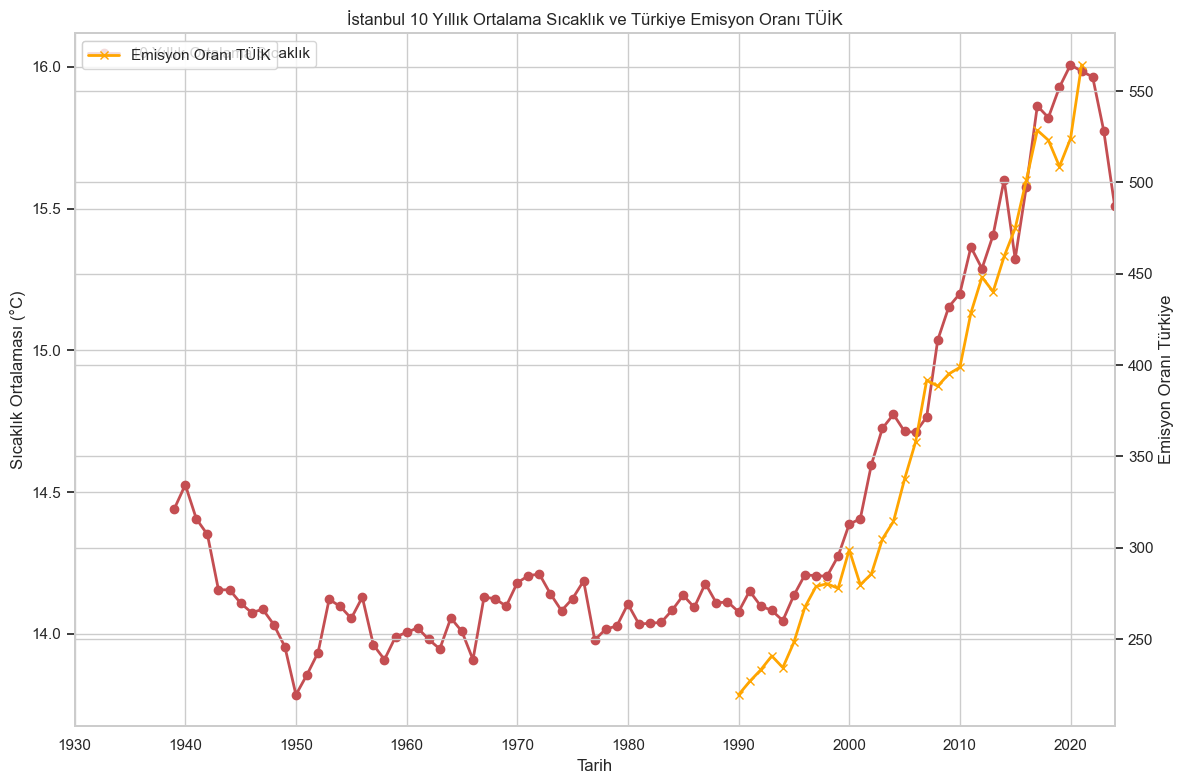

In [10]:
# Grafiğin boyutunu ayarlayın
plt.figure(figsize=(12, 8))

# Arka planı beyaz yerine grid tarzı yapın
sns.set(style="whitegrid")

# Birinci y-eksen verileri çizdirme (sıcaklık)
plt.plot(istanbul_ortalama["time"], ten_year_avg, label="10 Yıllık Ortalama Sıcaklık", linewidth=2, color="r", marker='o')

# Birinci y-eksen etiketlerini ve başlığı güncelleme
plt.xlabel("Tarih")
plt.ylabel("Sıcaklık Ortalaması (°C)")
plt.title("İstanbul 10 Yıllık Ortalama Sıcaklık ve Türkiye Emisyon Oranı TÜİK")
plt.legend()

# İlgili yıla odaklanmak için grafiği sınırlama
plt.xlim(istanbul_ortalama["time"].iloc[0], istanbul_ortalama["time"].iloc[-1])

# İkinci y-eksen verileri çizdirme (emisyon oranları)
ax2 = plt.gca().twinx()  # İkincil y-eksen oluşturma
ax2.plot(emisyon_tuik["Yıl"], emisyon_tuik["Toplam"], label="Emisyon Oranı TÜİK", linewidth=2, color="orange", marker='x')
ax2.set_ylabel("Emisyon Oranı Türkiye")  # İkincil y-eksen etiketi

plt.legend(



)

# Grafikleri gösterme
plt.tight_layout()
plt.savefig('grafikler/2.png')

plt.show()

In [11]:
#CAMBRIDGE VE OXFORD DESTEKLI OWID DATASINA GÖRE TR EMİSYON ORANLARINA BAKALIM
emisyon_owid = pd.read_csv("owid-co2-data.csv")

In [12]:
emisyon_owid

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1850,AFG,3752993.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1851,AFG,3767956.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.165,0.000,0.000,0.000,0.0,NaN,NaN,NaN,NaN
2,Afghanistan,1852,AFG,3783940.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.164,0.000,0.000,0.000,0.0,NaN,NaN,NaN,NaN
3,Afghanistan,1853,AFG,3800954.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.164,0.000,0.000,0.000,0.0,NaN,NaN,NaN,NaN
4,Afghanistan,1854,AFG,3818038.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.163,0.000,0.000,0.000,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50593,Zimbabwe,2017,ZWE,14751101.0,2.194784e+10,0.469,0.032,9.596,-0.937,-8.899,...,NaN,0.114,0.001,0.001,0.002,0.0,115.59,28.30,0.910,9.486
50594,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,0.558,0.037,11.795,2.199,22.920,...,NaN,0.114,0.001,0.001,0.002,0.0,118.22,30.83,0.771,6.537
50595,Zimbabwe,2019,ZWE,15354606.0,NaN,0.570,0.037,11.115,-0.681,-5.772,...,NaN,0.113,0.001,0.001,0.002,0.0,117.96,30.53,0.978,8.795
50596,Zimbabwe,2020,ZWE,15669663.0,NaN,0.570,0.036,10.608,-0.507,-4.559,...,NaN,0.112,0.001,0.001,0.002,0.0,NaN,NaN,1.006,9.481


In [13]:
emisyon_owid.loc[emisyon_owid.loc[emisyon_owid.country == "Turkey"]["co2"].dropna().index].columns
emisyon_owid = emisyon_owid.loc[emisyon_owid.loc[emisyon_owid.country == "Turkey"]["co2"].dropna().index][["country","year","co2","gas_co2","methane","nitrous_oxide","oil_co2",'other_industry_co2', 'primary_energy_consumption',"consumption_co2","energy_per_capita",'total_ghg']]
emisyon_owid = emisyon_owid.fillna(0)
emisyon_owid["total"] = emisyon_owid["co2"] + emisyon_owid["methane"] + emisyon_owid["nitrous_oxide"]
emisyon_owid_tur = emisyon_owid.copy()
emisyon_owid_tur = emisyon_owid_tur[["country","year","total_ghg","total","co2","methane","nitrous_oxide"]]
emisyon_owid_tur.loc[emisyon_owid_tur["total_ghg"]==0, "total_ghg"] = emisyon_owid_tur["total"]
emisyon_owid_tur.drop(columns="total", inplace=True)
emisyon_owid_tur['year'] = pd.to_datetime(emisyon_owid_tur['year'], format='%Y')

In [15]:
emisyon_owid_tur

,country,year,total_ghg,co2,methane,nitrous_oxide
46368,Turkey,1865-01-01,0.150,0.150,0.00,0.00
46369,Turkey,1866-01-01,0.209,0.209,0.00,0.00
46370,Turkey,1867-01-01,0.227,0.227,0.00,0.00
46371,Turkey,1868-01-01,0.176,0.176,0.00,0.00
46372,Turkey,1869-01-01,0.267,0.267,0.00,0.00
...,...,...,...,...,...,...
46520,Turkey,2017-01-01,472.270,430.220,44.98,32.87
46521,Turkey,2018-01-01,470.650,422.569,47.10,32.69
46522,Turkey,2019-01-01,459.860,401.720,48.54,34.75
46523,Turkey,2020-01-01,413.433,413.433,0.00,0.00


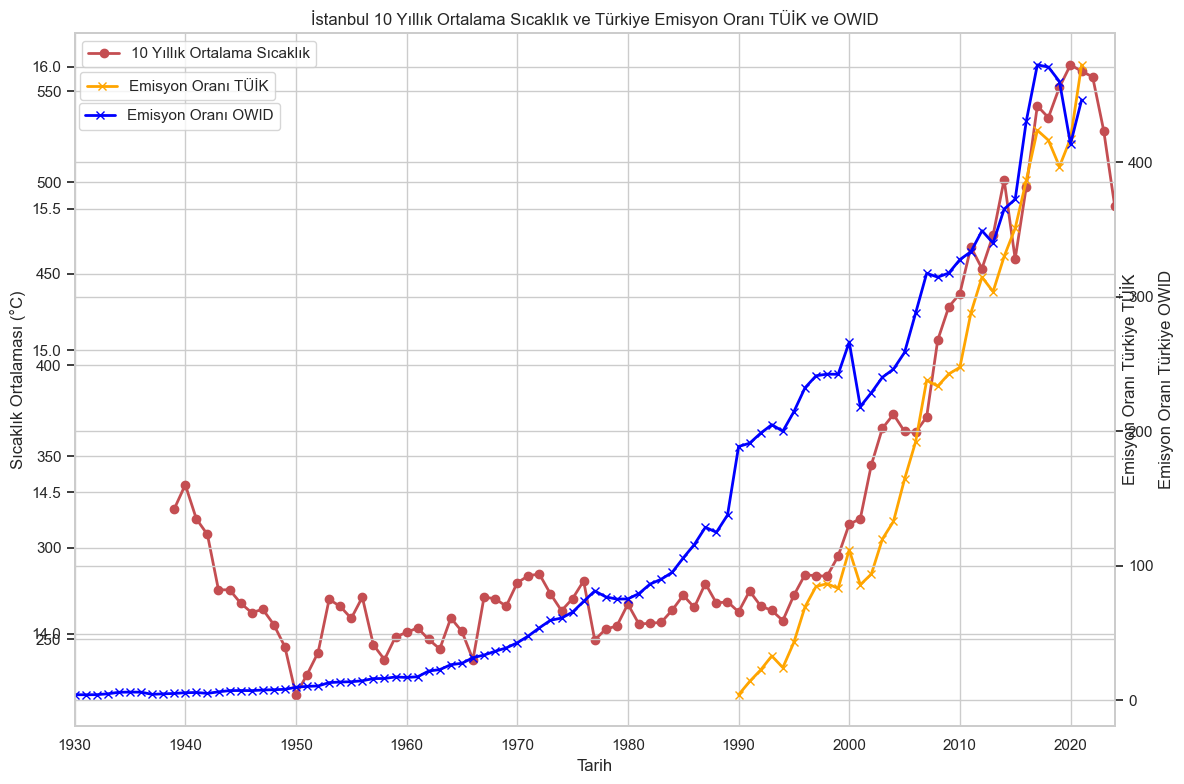

In [16]:
# Grafiğin boyutunu ayarlayın
plt.figure(figsize=(12, 8))

# Arka planı beyaz yerine grid tarzı yapın
sns.set(style="whitegrid")

# Birinci y-eksen verileri çizdirme (sıcaklık)
plt.plot(istanbul_ortalama["time"], ten_year_avg, label="10 Yıllık Ortalama Sıcaklık", linewidth=2, color="r", marker='o')

# Birinci y-eksen etiketlerini ve başlığı güncelleme
plt.xlabel("Tarih")
plt.ylabel("Sıcaklık Ortalaması (°C)")
plt.title("İstanbul 10 Yıllık Ortalama Sıcaklık ve Türkiye Emisyon Oranı TÜİK ve OWID")
plt.legend()

# İlgili yıla odaklanmak için grafiği sınırlama
plt.xlim(istanbul_ortalama["time"].iloc[0], istanbul_ortalama["time"].iloc[-1])

# İkinci y-eksen verileri çizdirme (emisyon oranları)
ax2 = plt.gca().twinx()  # İkincil y-eksen oluşturma
ax2.plot(emisyon_tuik["Yıl"], emisyon_tuik["Toplam"], label="Emisyon Oranı TÜİK", linewidth=2, color="orange", marker='x')
ax2.set_ylabel("Emisyon Oranı Türkiye TÜİK")  # İkincil y-eksen etiketi
plt.legend(bbox_to_anchor=(0.2, 0.9555))

# Üçüncü y-eksen verileri çizdirme (emisyon oranları)
ax3 = plt.gca().twinx()  
ax3.plot(emisyon_owid_tur[emisyon_owid_tur["year"] >= datetime(1930, 1, 1)]["year"], emisyon_owid_tur[emisyon_owid_tur["year"] >= datetime(1930, 1, 1)]["total_ghg"], label="Emisyon Oranı OWID", linewidth=2, color="blue", marker='x')
ax3.set_ylabel("Emisyon Oranı Türkiye OWID") 
plt.legend(bbox_to_anchor=(0.205, 0.91))


# Grafikleri gösterme
plt.tight_layout()
plt.savefig('grafikler/3.png')

plt.show()

## Yeşillik ve Sıcaklık

In [17]:
yesillik_istanbul = pd.read_excel("istanbul data/2022-yeil-alan-bilgileri.xlsx")
yesillik_istanbul.drop(columns="Unnamed: 20", inplace=True)

In [18]:
dikilen_agac_istanbul = pd.melt(yesillik_istanbul.loc[yesillik_istanbul["FAALİYET KONUSU"]=="Dikilen Ağaç Sayısı"].drop(columns="BİRİM"), id_vars=["FAALİYET KONUSU"], var_name="Year", value_name="Count")
bakim_agac_istanbul = pd.melt(yesillik_istanbul.loc[yesillik_istanbul["FAALİYET KONUSU"]=="Bakımı Yapılan Ağaç Sayısı"].drop(columns="BİRİM"), id_vars=["FAALİYET KONUSU"], var_name="Year", value_name="Count")
dikilen_cali_istanbul = pd.melt(yesillik_istanbul.loc[yesillik_istanbul["FAALİYET KONUSU"]=="Dikilen Çalı Sayısı"].drop(columns="BİRİM"), id_vars=["FAALİYET KONUSU"], var_name="Year", value_name="Count")

In [19]:
dikilen_agac_istanbul['year'] = pd.to_datetime(dikilen_agac_istanbul['Year'], format='%Y')
bakim_agac_istanbul['year'] = pd.to_datetime(bakim_agac_istanbul['Year'], format='%Y')
dikilen_cali_istanbul['year'] = pd.to_datetime(dikilen_cali_istanbul['Year'], format='%Y')

In [20]:
dikilen_agac_istanbul

,FAALİYET KONUSU,Year,Count,year
0,Dikilen Ağaç Sayısı,2004,99685.0,2004-01-01
1,Dikilen Ağaç Sayısı,2005,230000.0,2005-01-01
2,Dikilen Ağaç Sayısı,2006,215000.0,2006-01-01
3,Dikilen Ağaç Sayısı,2007,216724.0,2007-01-01
4,Dikilen Ağaç Sayısı,2008,198269.0,2008-01-01
5,Dikilen Ağaç Sayısı,2009,34637.0,2009-01-01
6,Dikilen Ağaç Sayısı,2010,40048.0,2010-01-01
7,Dikilen Ağaç Sayısı,2011,72514.0,2011-01-01
8,Dikilen Ağaç Sayısı,2012,166786.0,2012-01-01
9,Dikilen Ağaç Sayısı,2013,136795.0,2013-01-01


In [21]:
bakim_agac_istanbul['Count'] = bakim_agac_istanbul['Count'].astype(str).str.split('.').str[0].str[:-3]+'.'+ bakim_agac_istanbul['Count'].astype(str).str.split('.').str[0].str[-3:]
dikilen_agac_istanbul['Count'] = dikilen_agac_istanbul['Count'].astype(str).str.split('.').str[0].str[:-3]+'.'+ dikilen_agac_istanbul['Count'].astype(str).str.split('.').str[0].str[-3:]
emisyon_tuik["year"] = emisyon_tuik["Yıl"].dt.year
emisyon_tuik["total_ghg"] = emisyon_tuik["Toplam"]
bakim_agac_istanbul["Count"] = pd.to_numeric(bakim_agac_istanbul['Count']).round()
#bakim_agac_istanbul['Count'] = bakim_agac_istanbul['Count'].astype(str).str.replace('.', ',')
dikilen_agac_istanbul["Count"] = pd.to_numeric(dikilen_agac_istanbul['Count']).round()
#dikilen_agac_istanbul['Count'] = dikilen_agac_istanbul['Count'].astype(str).str.replace('.', ',')
dikilen_cali_istanbul["Count"] = pd.to_numeric(dikilen_cali_istanbul['Count']).round()

In [22]:
dikilen_cali_istanbul

,FAALİYET KONUSU,Year,Count,year
0,Dikilen Çalı Sayısı,2004,450000.0,2004-01-01
1,Dikilen Çalı Sayısı,2005,600000.0,2005-01-01
2,Dikilen Çalı Sayısı,2006,200000.0,2006-01-01
3,Dikilen Çalı Sayısı,2007,155657.0,2007-01-01
4,Dikilen Çalı Sayısı,2008,81113.0,2008-01-01
5,Dikilen Çalı Sayısı,2009,16259.0,2009-01-01
6,Dikilen Çalı Sayısı,2010,156450.0,2010-01-01
7,Dikilen Çalı Sayısı,2011,32750.0,2011-01-01
8,Dikilen Çalı Sayısı,2012,476728.0,2012-01-01
9,Dikilen Çalı Sayısı,2013,640235.0,2013-01-01


In [23]:
bakim_agac_istanbul

,FAALİYET KONUSU,Year,Count,year
0,Bakımı Yapılan Ağaç Sayısı,2004,31.0,2004-01-01
1,Bakımı Yapılan Ağaç Sayısı,2005,36.0,2005-01-01
2,Bakımı Yapılan Ağaç Sayısı,2006,63.0,2006-01-01
3,Bakımı Yapılan Ağaç Sayısı,2007,74.0,2007-01-01
4,Bakımı Yapılan Ağaç Sayısı,2008,57.0,2008-01-01
5,Bakımı Yapılan Ağaç Sayısı,2009,36.0,2009-01-01
6,Bakımı Yapılan Ağaç Sayısı,2010,17.0,2010-01-01
7,Bakımı Yapılan Ağaç Sayısı,2011,21.0,2011-01-01
8,Bakımı Yapılan Ağaç Sayısı,2012,81.0,2012-01-01
9,Bakımı Yapılan Ağaç Sayısı,2013,102.0,2013-01-01


In [24]:
dikilen_agac_istanbul

,FAALİYET KONUSU,Year,Count,year
0,Dikilen Ağaç Sayısı,2004,100.0,2004-01-01
1,Dikilen Ağaç Sayısı,2005,230.0,2005-01-01
2,Dikilen Ağaç Sayısı,2006,215.0,2006-01-01
3,Dikilen Ağaç Sayısı,2007,217.0,2007-01-01
4,Dikilen Ağaç Sayısı,2008,198.0,2008-01-01
5,Dikilen Ağaç Sayısı,2009,35.0,2009-01-01
6,Dikilen Ağaç Sayısı,2010,40.0,2010-01-01
7,Dikilen Ağaç Sayısı,2011,73.0,2011-01-01
8,Dikilen Ağaç Sayısı,2012,167.0,2012-01-01
9,Dikilen Ağaç Sayısı,2013,137.0,2013-01-01


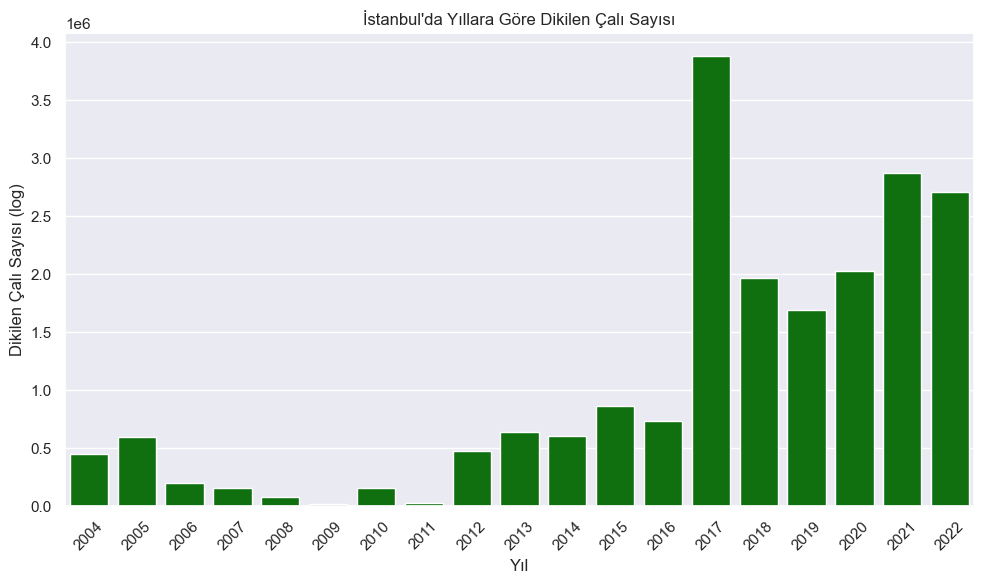

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn temasını ayarla
sns.set_theme()
plt.figure(figsize=(10, 6))  # Grafik boyutunu belirleme

# Çubuk grafiği oluştur
g = sns.barplot(data=dikilen_cali_istanbul, x="Year", y="Count", color="green")  # Çubuk rengini sabit yeşil yap


# Eksen etiketleri ve başlığı ekle
plt.xlabel("Yıl")
plt.ylabel("Dikilen Çalı Sayısı (log)")
plt.title("İstanbul'da Yıllara Göre Dikilen Çalı Sayısı")

# X eksenindeki yıl etiketlerini döndürmek için
plt.xticks(rotation=45)  # Eksen etiketlerini 45 derece döndür
plt.tight_layout()  # Grafik öğelerinin sığdırılması

plt.savefig('grafikler/4.png')

# Grafiği göster
plt.show()


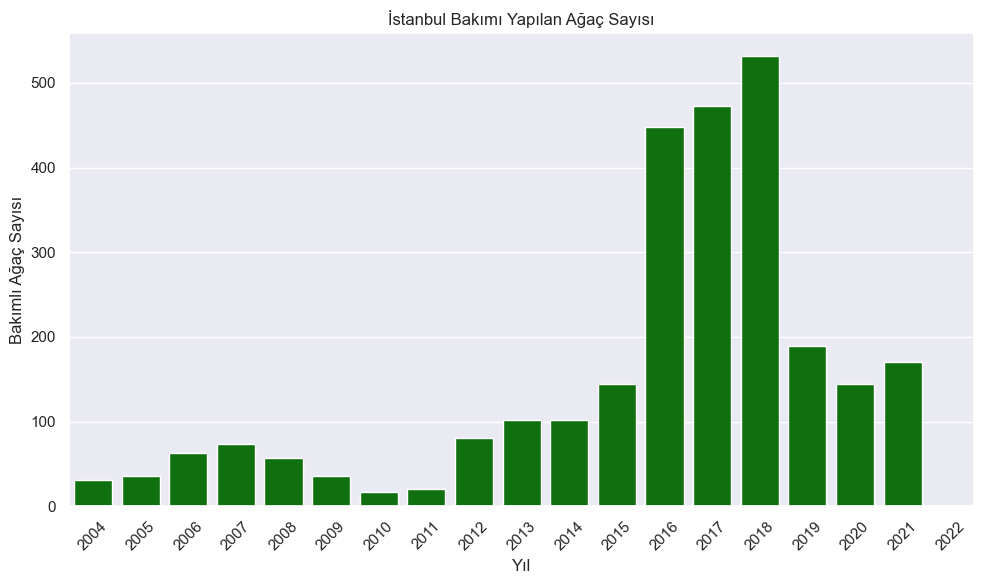

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn temasını ayarla
sns.set_theme()
plt.figure(figsize=(10, 6))  # Grafik boyutunu belirleme

# Çubuk grafiği oluştur
sns.barplot(data=bakim_agac_istanbul, x="Year", y="Count", color="green")  # Çubuk rengini sabit yeşil yap

# Eksen etiketleri ve başlığı ekle
plt.xlabel("Yıl")
plt.ylabel("Bakımlı Ağaç Sayısı")
plt.title("İstanbul Bakımı Yapılan Ağaç Sayısı")

# X eksenindeki yıl etiketlerini döndürmek için
plt.xticks(rotation=45)  # Eksen etiketlerini 45 derece döndür
plt.tight_layout()  # Grafik öğelerinin sığdırılması

plt.savefig('grafikler/5.png')

# Grafiği göster
plt.show()


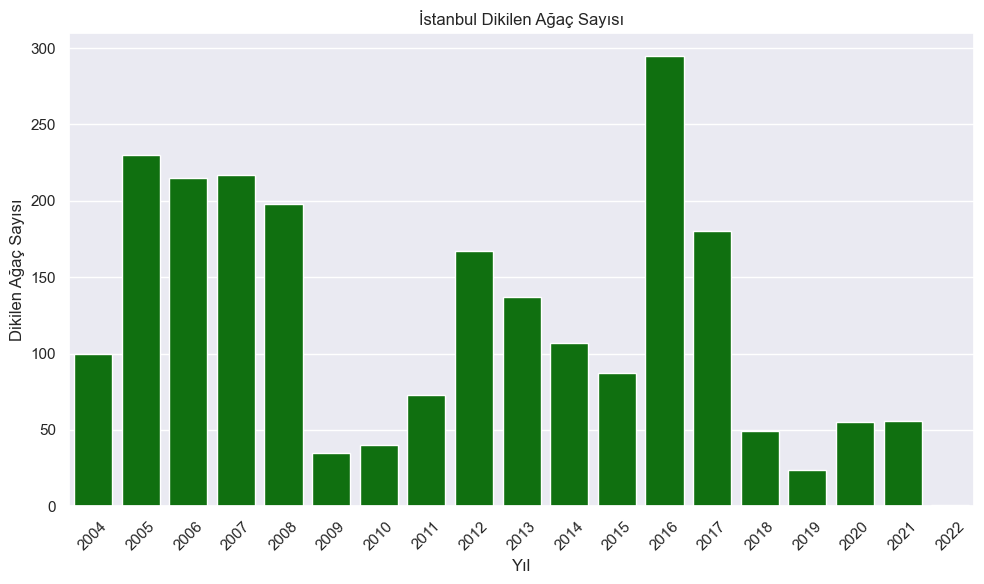

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn temasını ayarla
sns.set_theme()
plt.figure(figsize=(10, 6))  # Grafik boyutunu belirleme

# Çubuk grafiği oluştur
sns.barplot(data=dikilen_agac_istanbul, x="Year", y="Count", color="green")  # Çubuk rengini sabit yeşil yap

# Eksen etiketleri ve başlığı ekle
plt.xlabel("Yıl")
plt.ylabel("Dikilen Ağaç Sayısı")
plt.title("İstanbul Dikilen Ağaç Sayısı")

# X eksenindeki yıl etiketlerini döndürmek için
plt.xticks(rotation=45)  # Eksen etiketlerini 45 derece döndür
plt.tight_layout()  # Grafik öğelerinin sığdırılması

plt.savefig('grafikler/6.png')

# Grafiği göster
plt.show()


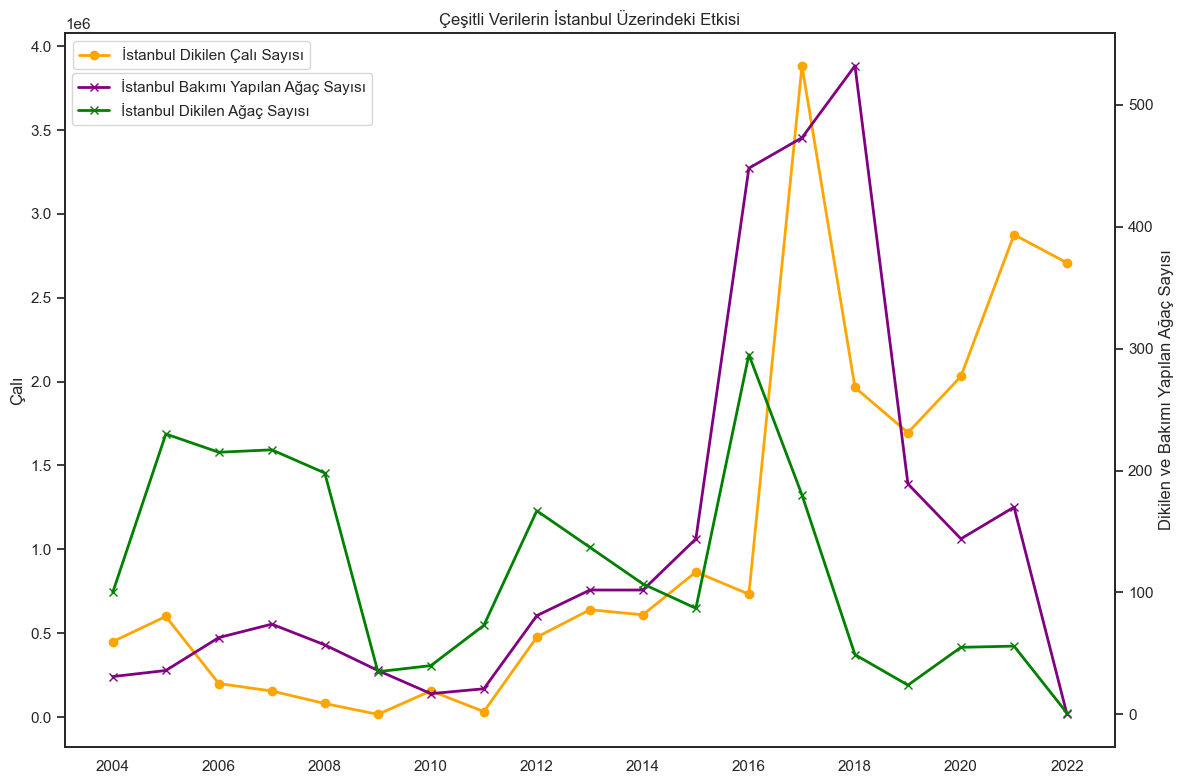

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Grafiğin boyutunu ayarlayın
plt.figure(figsize=(12, 8))

# Arka planı beyaz yerine grid tarzı yapın
sns.set_theme(style='white')

# Birinci y-eksen verileri çizdirme (sıcaklık)
plt.plot(dikilen_cali_istanbul["year"], dikilen_cali_istanbul["Count"], label="İstanbul Dikilen Çalı Sayısı", linewidth=2, color="orange", marker='o')
plt.legend(loc='upper left')
plt.ylabel("Çalı")

# İkinci y-eksen verileri çizdirme (emisyon oranları)
ax2 = plt.gca().twinx()  
ax2.plot(bakim_agac_istanbul["year"], bakim_agac_istanbul["Count"], label="İstanbul Bakımı Yapılan Ağaç Sayısı", linewidth=2, color="purple", marker='x')
plt.legend(bbox_to_anchor=(0.295, 0.9555))
plt.ylabel("Dikilen ve Bakımı Yapılan Ağaç Sayısı")

# Üçüncü y-eksen verileri çizdirme (Dikilen Ağaç Sayısı)
ax2.plot(dikilen_agac_istanbul["year"], dikilen_agac_istanbul["Count"], label="İstanbul Dikilen Ağaç Sayısı", linewidth=2, color="green", marker='x')
plt.legend(bbox_to_anchor=(0.3, 0.955))
plt.ylabel("Dikilen ve Bakımı Yapılan Ağaç Sayısı")

# Tüm y-eksen etiketlerini güncelleme

# Başlığı güncelleme
plt.title("Çeşitli Verilerin İstanbul Üzerindeki Etkisi")


# Grafikleri gösterme
plt.tight_layout()

plt.savefig('grafikler/7.png')
plt.show()


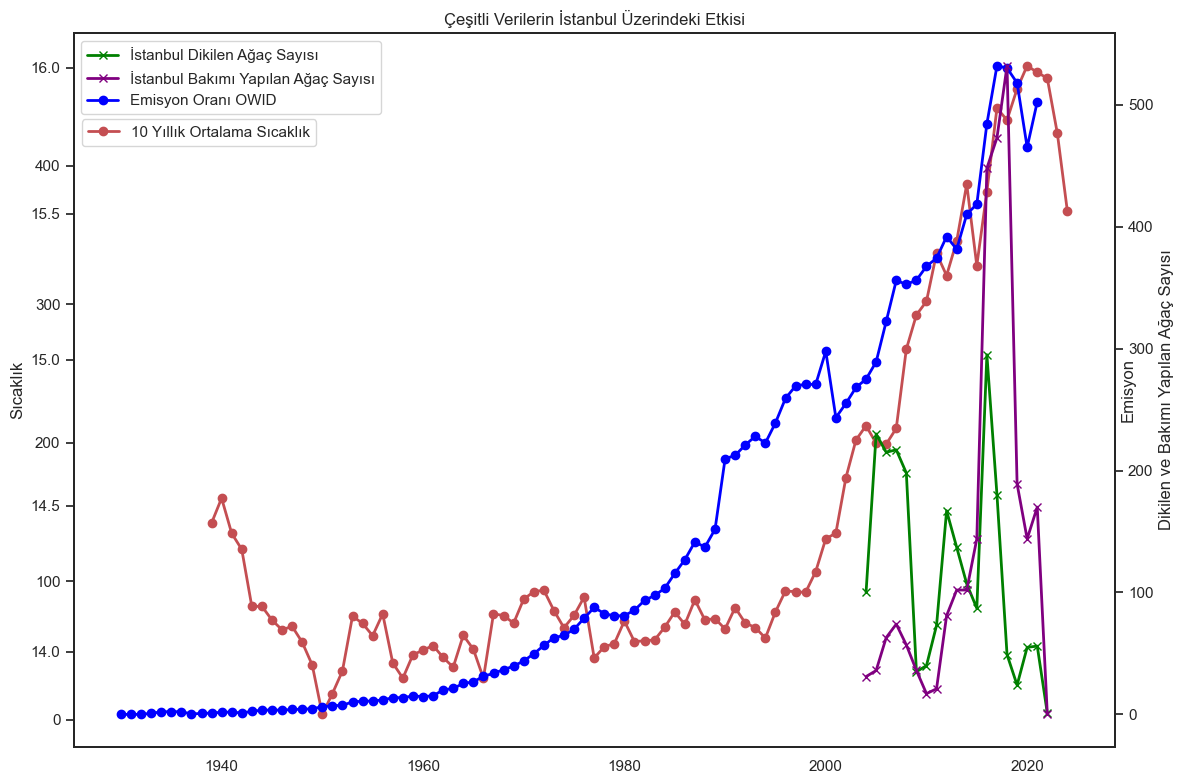

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Grafiğin boyutunu ayarlayın
plt.figure(figsize=(12, 8))

# Arka planı beyaz yerine grid tarzı yapın
sns.set_theme(style='white')

# Birinci y-eksen verileri çizdirme (sıcaklık)
plt.plot(istanbul_ortalama["time"], ten_year_avg, label="10 Yıllık Ortalama Sıcaklık", linewidth=2, color="r", marker='o')
plt.legend(bbox_to_anchor=(0.240, 0.89))
plt.ylabel("Sıcaklık")

# İkinci y-eksen verileri çizdirme (emisyon oranları)
ax2 = plt.gca().twinx()  
ax2.plot(emisyon_owid_tur[emisyon_owid_tur["year"] >= datetime(1930, 1, 1)]["year"], emisyon_owid_tur[emisyon_owid_tur["year"] >= datetime(1930, 1, 1)]["total_ghg"], label="Emisyon Oranı OWID", linewidth=2, color="blue", marker='o')
plt.ylabel("Emisyon")

# Üçüncü y-eksen verileri çizdirme (Dikilen Ağaç Sayısı)
ax3 = plt.gca().twinx()  # İkincil y-eksen oluşturma
ax3.plot(dikilen_agac_istanbul["year"], dikilen_agac_istanbul["Count"], label="İstanbul Dikilen Ağaç Sayısı", linewidth=2, color="green", marker='x')
ax3.plot(bakim_agac_istanbul["year"], bakim_agac_istanbul["Count"], label="İstanbul Bakımı Yapılan Ağaç Sayısı", linewidth=2, color="purple", marker='x')
plt.ylabel("Dikilen ve Bakımı Yapılan Ağaç Sayısı")

# Başlığı güncelleme
plt.title("Çeşitli Verilerin İstanbul Üzerindeki Etkisi")

# Tüm çizgi açıklamalarını ekleme
lines = plt.gca().get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper left')

# Grafikleri gösterme
plt.tight_layout()
plt.savefig('grafikler/8.png')

plt.show()


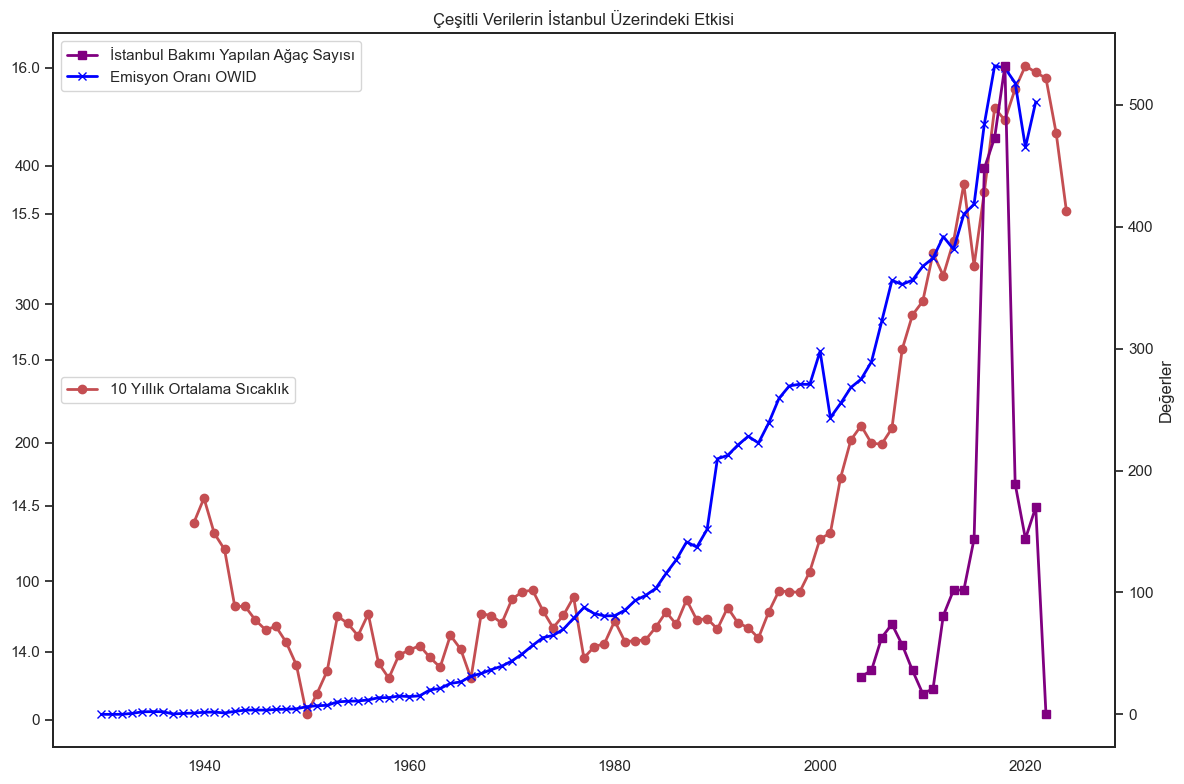

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Grafiğin boyutunu ayarlayın
plt.figure(figsize=(12, 8))

# Arka planı beyaz yerine grid tarzı yapın
sns.set_theme(style='white')

# Birinci y-eksen verileri çizdirme (sıcaklık)
plt.plot(istanbul_ortalama["time"], ten_year_avg, label="10 Yıllık Ortalama Sıcaklık", linewidth=2, color="r", marker='o')
plt.legend(loc='center left')

# İkinci y-eksen verileri çizdirme (emisyon oranları)
ax2 = plt.gca().twinx()  
ax2.plot(emisyon_owid_tur[emisyon_owid_tur["year"] >= datetime(1930, 1, 1)]["year"], emisyon_owid_tur[emisyon_owid_tur["year"] >= datetime(1930, 1, 1)]["total_ghg"], label="Emisyon Oranı OWID", linewidth=2, color="blue", marker='x')

# Üçüncü y-eksen verileri çizdirme (bakımı yapılan ağaç sayısı)
ax3 = plt.gca().twinx()
ax3.plot(bakim_agac_istanbul["year"], bakim_agac_istanbul["Count"], label="İstanbul Bakımı Yapılan Ağaç Sayısı", linewidth=2, color="purple", marker='s')

# Tüm y-eksen etiketlerini güncelleme
plt.ylabel("Değerler")

# Başlığı güncelleme
plt.title("Çeşitli Verilerin İstanbul Üzerindeki Etkisi")

# Tüm çizgi açıklamalarını ekleme
lines = plt.gca().get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper left')

# Grafikleri gösterme
plt.tight_layout()
plt.show()


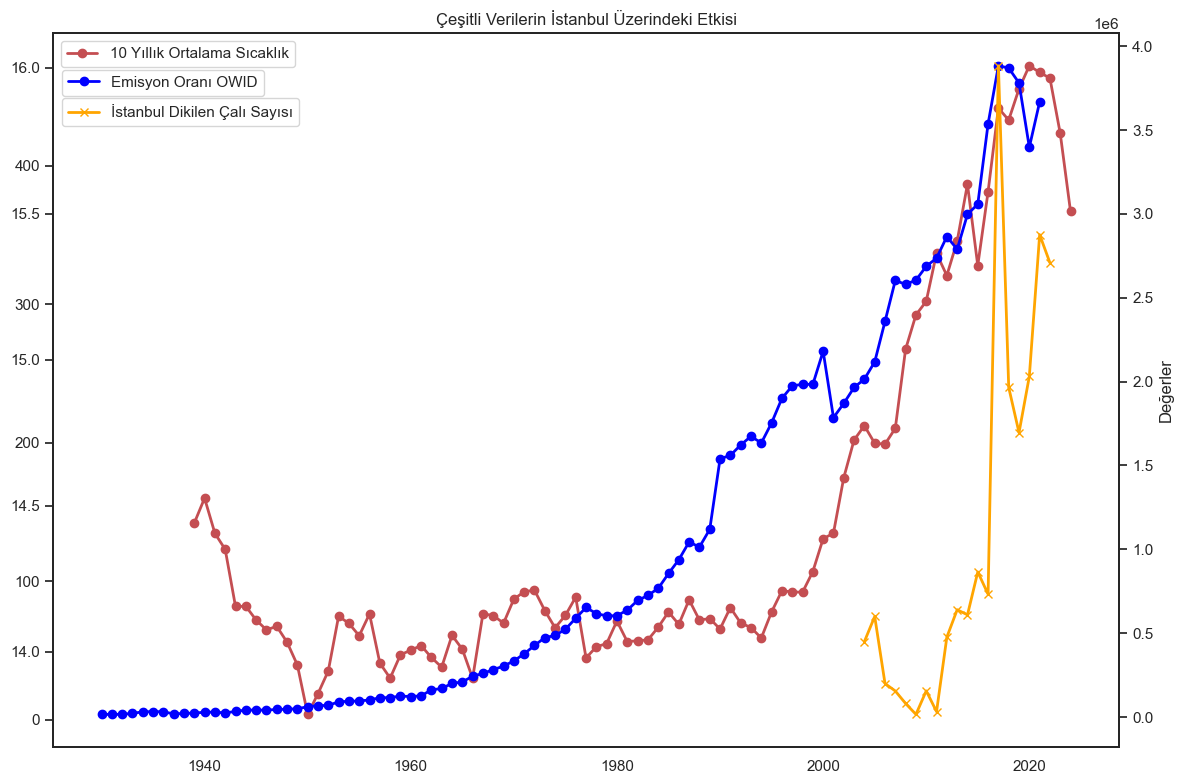

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Grafiğin boyutunu ayarlayın
plt.figure(figsize=(12, 8))

# Arka planı beyaz yerine grid tarzı yapın
sns.set_theme(style='white')

# Birinci y-eksen verileri çizdirme (sıcaklık)
plt.plot(istanbul_ortalama["time"], ten_year_avg, label="10 Yıllık Ortalama Sıcaklık", linewidth=2, color="r", marker='o')
plt.legend(loc='upper left')

# İkinci y-eksen verileri çizdirme (emisyon oranları)
ax2 = plt.gca().twinx()  
ax2.plot(emisyon_owid_tur[emisyon_owid_tur["year"] >= datetime(1930, 1, 1)]["year"], emisyon_owid_tur[emisyon_owid_tur["year"] >= datetime(1930, 1, 1)]["total_ghg"], label="Emisyon Oranı OWID", linewidth=2, color="blue", marker='o')
plt.legend(bbox_to_anchor=(0.205, 0.96))

# Üçüncü y-eksen verileri çizdirme (dikilen çalı sayısı)
ax3 = plt.gca().twinx()
ax3.plot(dikilen_cali_istanbul["year"], dikilen_cali_istanbul["Count"], label="İstanbul Dikilen Çalı Sayısı", linewidth=2, color="orange", marker='x')
plt.legend(bbox_to_anchor=(0.238, 0.92))

# Tüm y-eksen etiketlerini güncelleme
plt.ylabel("Değerler")

# Başlığı güncelleme
plt.title("Çeşitli Verilerin İstanbul Üzerindeki Etkisi")

# Grafikleri gösterme
plt.tight_layout()

plt.savefig('grafikler/9.png')

plt.show()


## Su ve Sıcaklık

In [32]:
yagis_baraj = pd.read_excel("istanbul data/ibb_yags_verileri_2011-23.xlsx")
yagis_baraj['year'] = pd.to_datetime(yagis_baraj['Tarih'], format='%Y')

In [33]:
yagis_baraj

,Tarih,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere,year
0,2011-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2011-01-01
1,2011-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2011-01-02
2,2011-01-03,0.00,0.00,0.00,0.42,1.37,0.87,0.2,2.26,1.89,2011-01-03
3,2011-01-04,8.08,10.01,11.64,18.82,9.64,14.72,13.5,8.20,10.37,2011-01-04
4,2011-01-05,2.78,8.48,7.09,3.42,0.83,4.31,4.3,1.44,1.60,2011-01-05
...,...,...,...,...,...,...,...,...,...,...,...
4468,2023-03-27,2.65,2.20,5.41,9.20,1.71,2.50,4.0,4.30,2.80,2023-03-27
4469,2023-03-28,9.66,12.00,25.87,3.20,18.89,16.25,20.3,7.10,5.40,2023-03-28
4470,2023-03-29,20.01,21.80,37.92,11.40,16.92,16.25,14.9,1.60,1.20,2023-03-29
4471,2023-03-30,3.21,1.60,3.71,1.60,2.08,1.75,2.6,0.00,0.00,2023-03-30


In [34]:
# Tarih sütununu pandas'ın datetime formatına çevirin
yagis_baraj['year'] = pd.to_datetime(yagis_baraj['year'])

# Tarihe göre gruplayıp aylık ortalama değerleri hesaplayın
yagis_baraj['month'] = yagis_baraj['year'].dt.month
yagis_baraj['year'] = yagis_baraj['year'].dt.year

In [35]:
yagis_baraj

,Tarih,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere,year,month
0,2011-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2011,1
1,2011-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2011,1
2,2011-01-03,0.00,0.00,0.00,0.42,1.37,0.87,0.2,2.26,1.89,2011,1
3,2011-01-04,8.08,10.01,11.64,18.82,9.64,14.72,13.5,8.20,10.37,2011,1
4,2011-01-05,2.78,8.48,7.09,3.42,0.83,4.31,4.3,1.44,1.60,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4468,2023-03-27,2.65,2.20,5.41,9.20,1.71,2.50,4.0,4.30,2.80,2023,3
4469,2023-03-28,9.66,12.00,25.87,3.20,18.89,16.25,20.3,7.10,5.40,2023,3
4470,2023-03-29,20.01,21.80,37.92,11.40,16.92,16.25,14.9,1.60,1.20,2023,3
4471,2023-03-30,3.21,1.60,3.71,1.60,2.08,1.75,2.6,0.00,0.00,2023,3


In [36]:
# istanbul ortalama'daki aynı formatta year sütunu ekliyorum
yagis_baraj['yearS'] = pd.to_datetime(yagis_baraj['year'].astype(str) + '-12-31')

In [37]:
yagis_yillik_istanbul = yagis_baraj.groupby("year").sum().drop(columns="month")
yagis_yillik_istanbul.reset_index(drop=False, inplace=True)
yagis_yillik_istanbul

,year,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere
0,2011,450.95,487.43,500.62,764.17,429.46,499.59,527.07,988.25,1095.06
1,2012,799.44,990.00,758.09,863.47,618.79,576.75,852.19,1046.55,1048.16
2,2013,436.51,556.56,430.61,701.69,445.87,445.24,496.72,709.73,777.00
3,2014,795.35,847.78,620.82,1253.16,586.00,796.73,919.38,1328.81,1339.93
4,2015,824.41,926.99,789.99,791.40,579.09,610.58,716.08,936.86,805.68
5,2016,798.29,946.75,765.06,748.55,519.37,665.86,803.45,998.72,807.43
6,2017,721.40,828.29,720.76,910.11,644.99,612.90,797.94,1357.73,1099.76
7,2018,842.04,814.45,546.32,1042.66,767.87,866.87,723.46,1025.59,858.58
8,2019,583.29,646.96,415.37,586.90,447.24,482.90,573.80,604.84,584.77
9,2020,903.93,638.94,783.55,869.61,791.39,675.63,795.56,643.13,710.50


In [38]:
# istanbul ortalama'daki aynı formatta year sütunu ekliyorum
yagis_yillik_istanbul['yearS'] = pd.to_datetime(yagis_yillik_istanbul['year'].astype(str) + '-12-31')

In [39]:
yagis_yillik_istanbul["TotalBaraj"]=yagis_yillik_istanbul["Ömerli"]+yagis_yillik_istanbul["Darlik"]+yagis_yillik_istanbul["Elmali"]+yagis_yillik_istanbul["Terkos"]+yagis_yillik_istanbul["B.çekmece"]+yagis_yillik_istanbul["Sazlidere"]+yagis_yillik_istanbul["Alibey"]+yagis_yillik_istanbul["Kazandere"]+yagis_yillik_istanbul["Pabuçdere"]
yagis_yillik_istanbul

,year,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere,yearS,TotalBaraj
0,2011,450.95,487.43,500.62,764.17,429.46,499.59,527.07,988.25,1095.06,2011-12-31,5742.60
1,2012,799.44,990.00,758.09,863.47,618.79,576.75,852.19,1046.55,1048.16,2012-12-31,7553.44
2,2013,436.51,556.56,430.61,701.69,445.87,445.24,496.72,709.73,777.00,2013-12-31,4999.93
3,2014,795.35,847.78,620.82,1253.16,586.00,796.73,919.38,1328.81,1339.93,2014-12-31,8487.96
4,2015,824.41,926.99,789.99,791.40,579.09,610.58,716.08,936.86,805.68,2015-12-31,6981.08
5,2016,798.29,946.75,765.06,748.55,519.37,665.86,803.45,998.72,807.43,2016-12-31,7053.48
6,2017,721.40,828.29,720.76,910.11,644.99,612.90,797.94,1357.73,1099.76,2017-12-31,7693.88
7,2018,842.04,814.45,546.32,1042.66,767.87,866.87,723.46,1025.59,858.58,2018-12-31,7487.84
8,2019,583.29,646.96,415.37,586.90,447.24,482.90,573.80,604.84,584.77,2019-12-31,4926.07
9,2020,903.93,638.94,783.55,869.61,791.39,675.63,795.56,643.13,710.50,2020-12-31,6812.24


In [40]:
istanbul_ortalama.loc[istanbul_ortalama["time"] >= pd.to_datetime('2010-01-01')]

,time,tavg
81,2010-12-31,16.491667
82,2011-12-31,14.800000
83,2012-12-31,16.225000
84,2013-12-31,16.233333
85,2014-12-31,11.850000
86,2015-12-31,17.085714
87,2016-12-31,17.570000
88,2017-12-31,15.925000
89,2018-12-31,17.127273
90,2019-12-31,16.766667


In [41]:
su_tuketim_m3 = pd.read_excel("istanbul data/m3-in-total-since-1991.xlsx")
su_tuketim_yesil = pd.read_excel("istanbul data/yllara-gore-yeil-alanlar-icin-harcanan-su-miktar.xlsx")

In [42]:
su_tuketim_yesil

,Yıl,Su Tüketimi (m3)
0,2017,13417588
1,2018,13769091
2,2019,16830146
3,2020,17542920
4,2021,15199415
5,2022,18825290


In [43]:
su_tuketim_m3

,YIL,TOPLAM M3
0,1991,223190566
1,1992,254137022
2,1993,254784311
3,1994,251308053
4,1995,252420061
5,1996,327129773
6,1997,380891741
7,1998,372865412
8,1999,382178108
9,2000,389242782


In [44]:
baraj_doluluk_istanbul = pd.read_excel("istanbul data/istanbul-dams-daily-occupancy-rates.xlsx")
#totali toplayıp eleman sayısına bölüyorum
baraj_doluluk_istanbul["TotalBaraj"]=baraj_doluluk_istanbul["Ömerli"]+baraj_doluluk_istanbul["Istrancalar"]+baraj_doluluk_istanbul["Darlık"]+baraj_doluluk_istanbul["Elmalı"]+baraj_doluluk_istanbul["Terkos"]+baraj_doluluk_istanbul["Büyükçekmece"]+baraj_doluluk_istanbul["Sazlıdere"]+baraj_doluluk_istanbul["Alibey"]+baraj_doluluk_istanbul["Kazandere"]+baraj_doluluk_istanbul["Pabuçdere"]
baraj_doluluk_istanbul["TotalBaraj"]=baraj_doluluk_istanbul["TotalBaraj"]/10
#yıllık ortalamaları buluyorum
baraj_doluluk_istanbul["Tarih"] = pd.to_datetime(baraj_doluluk_istanbul["Tarih"])  # Convert "Tarih" column to datetime
baraj_doluluk_istanbul["year"] = baraj_doluluk_istanbul["Tarih"].dt.year  # Extract year from the datetime column
yillik_ort = baraj_doluluk_istanbul.groupby("year")["TotalBaraj"].mean()
baraj_doluluk_istanbul["yillik_ort"] = baraj_doluluk_istanbul["year"].map(yillik_ort)

baraj_doluluk_istanbul

,Tarih,Ömerli,Darlık,Elmalı,Terkos,Alibey,Büyükçekmece,Sazlıdere,Kazandere,Pabuçdere,Istrancalar,TotalBaraj,year,yillik_ort
0,2000-10-23,0.652551,0.750151,0.789792,0.708568,0.0000,0.521442,0.505489,0.057499,0.068553,0.110953,0.416500,2000,0.420412
1,2000-10-24,0.659731,0.773031,0.817187,0.710344,0.0000,0.521442,0.506952,0.057499,0.069092,0.077226,0.419250,2000,0.420412
2,2000-10-25,0.663327,0.787929,0.826667,0.708568,0.0000,0.519666,0.506952,0.057499,0.069361,0.105593,0.424556,2000,0.420412
3,2000-10-26,0.662608,0.793250,0.828125,0.706792,0.0000,0.517889,0.506952,0.057499,0.069624,0.114171,0.425691,2000,0.420412
4,2000-10-27,0.660450,0.795911,0.828125,0.706792,0.0000,0.516113,0.505489,0.057499,0.066667,0.114017,0.425106,2000,0.420412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8190,2023-03-27,0.562400,0.473100,0.314400,0.318300,0.1165,0.297600,0.324100,0.085900,0.090800,0.396100,0.297920,2023,0.270357
8191,2023-03-28,0.567200,0.474900,0.327100,0.319800,0.1196,0.301000,0.325300,0.085400,0.089500,0.415900,0.302570,2023,0.270357
8192,2023-03-29,0.581500,0.491100,0.374200,0.325700,0.1310,0.307700,0.327700,0.092000,0.095900,0.428700,0.315550,2023,0.270357
8193,2023-03-30,0.594700,0.508700,0.396400,0.327200,0.1409,0.309400,0.327000,0.093900,0.096800,0.425100,0.322010,2023,0.270357


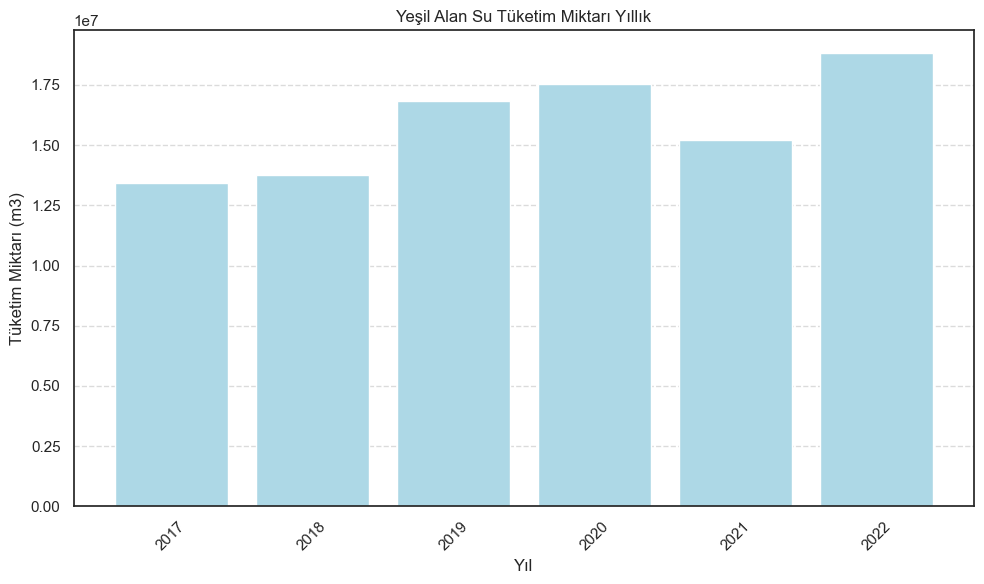

In [45]:
su_tuketim_yesil["Su Tüketimi (m3)"] = su_tuketim_yesil['Su Tüketimi (m3)'].astype(float)


plt.figure(figsize=(10, 6))  # Grafik boyutunu belirleme
plt.bar(su_tuketim_yesil["Yıl"], su_tuketim_yesil["Su Tüketimi (m3)"], color="lightblue")
plt.xlabel("Yıl")
plt.ylabel("Tüketim Miktarı (m3)")
plt.title("Yeşil Alan Su Tüketim Miktarı Yıllık")
plt.xticks(rotation=45)  # Eksen etiketlerini 45 derece döndürme
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y ekseni üzerinde ızgaralar ekler
plt.tight_layout()  # Grafik öğelerinin sığdırılması
plt.savefig('grafikler/10.png')

plt.show()

In [46]:
yagis_yillik_istanbul

,year,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere,yearS,TotalBaraj
0,2011,450.95,487.43,500.62,764.17,429.46,499.59,527.07,988.25,1095.06,2011-12-31,5742.60
1,2012,799.44,990.00,758.09,863.47,618.79,576.75,852.19,1046.55,1048.16,2012-12-31,7553.44
2,2013,436.51,556.56,430.61,701.69,445.87,445.24,496.72,709.73,777.00,2013-12-31,4999.93
3,2014,795.35,847.78,620.82,1253.16,586.00,796.73,919.38,1328.81,1339.93,2014-12-31,8487.96
4,2015,824.41,926.99,789.99,791.40,579.09,610.58,716.08,936.86,805.68,2015-12-31,6981.08
5,2016,798.29,946.75,765.06,748.55,519.37,665.86,803.45,998.72,807.43,2016-12-31,7053.48
6,2017,721.40,828.29,720.76,910.11,644.99,612.90,797.94,1357.73,1099.76,2017-12-31,7693.88
7,2018,842.04,814.45,546.32,1042.66,767.87,866.87,723.46,1025.59,858.58,2018-12-31,7487.84
8,2019,583.29,646.96,415.37,586.90,447.24,482.90,573.80,604.84,584.77,2019-12-31,4926.07
9,2020,903.93,638.94,783.55,869.61,791.39,675.63,795.56,643.13,710.50,2020-12-31,6812.24


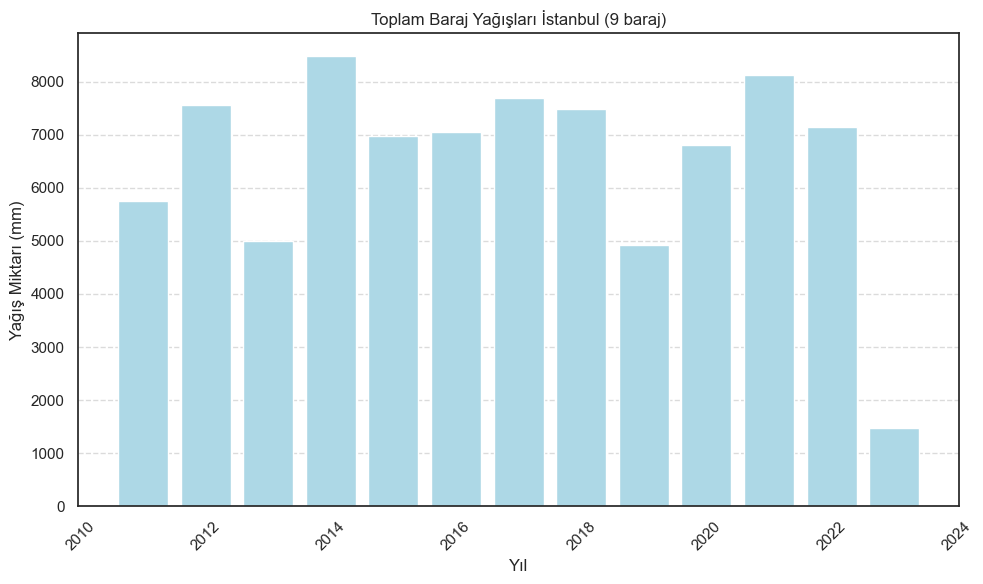

In [47]:
plt.figure(figsize=(10, 6))  # Grafik boyutunu belirleme
plt.bar(yagis_yillik_istanbul["year"], yagis_yillik_istanbul["TotalBaraj"], color="lightblue")
plt.xlabel("Yıl")
plt.ylabel("Yağış Miktarı (mm)")
plt.title("Toplam Baraj Yağışları İstanbul (9 baraj)")
plt.xticks(rotation=45)  # Eksen etiketlerini 45 derece döndürme
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y ekseni üzerinde ızgaralar ekler
plt.tight_layout()  # Grafik öğelerinin sığdırılması
plt.savefig('grafikler/11.png')

plt.show()

In [48]:
baraj_doluluk_istanbul

,Tarih,Ömerli,Darlık,Elmalı,Terkos,Alibey,Büyükçekmece,Sazlıdere,Kazandere,Pabuçdere,Istrancalar,TotalBaraj,year,yillik_ort
0,2000-10-23,0.652551,0.750151,0.789792,0.708568,0.0000,0.521442,0.505489,0.057499,0.068553,0.110953,0.416500,2000,0.420412
1,2000-10-24,0.659731,0.773031,0.817187,0.710344,0.0000,0.521442,0.506952,0.057499,0.069092,0.077226,0.419250,2000,0.420412
2,2000-10-25,0.663327,0.787929,0.826667,0.708568,0.0000,0.519666,0.506952,0.057499,0.069361,0.105593,0.424556,2000,0.420412
3,2000-10-26,0.662608,0.793250,0.828125,0.706792,0.0000,0.517889,0.506952,0.057499,0.069624,0.114171,0.425691,2000,0.420412
4,2000-10-27,0.660450,0.795911,0.828125,0.706792,0.0000,0.516113,0.505489,0.057499,0.066667,0.114017,0.425106,2000,0.420412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8190,2023-03-27,0.562400,0.473100,0.314400,0.318300,0.1165,0.297600,0.324100,0.085900,0.090800,0.396100,0.297920,2023,0.270357
8191,2023-03-28,0.567200,0.474900,0.327100,0.319800,0.1196,0.301000,0.325300,0.085400,0.089500,0.415900,0.302570,2023,0.270357
8192,2023-03-29,0.581500,0.491100,0.374200,0.325700,0.1310,0.307700,0.327700,0.092000,0.095900,0.428700,0.315550,2023,0.270357
8193,2023-03-30,0.594700,0.508700,0.396400,0.327200,0.1409,0.309400,0.327000,0.093900,0.096800,0.425100,0.322010,2023,0.270357


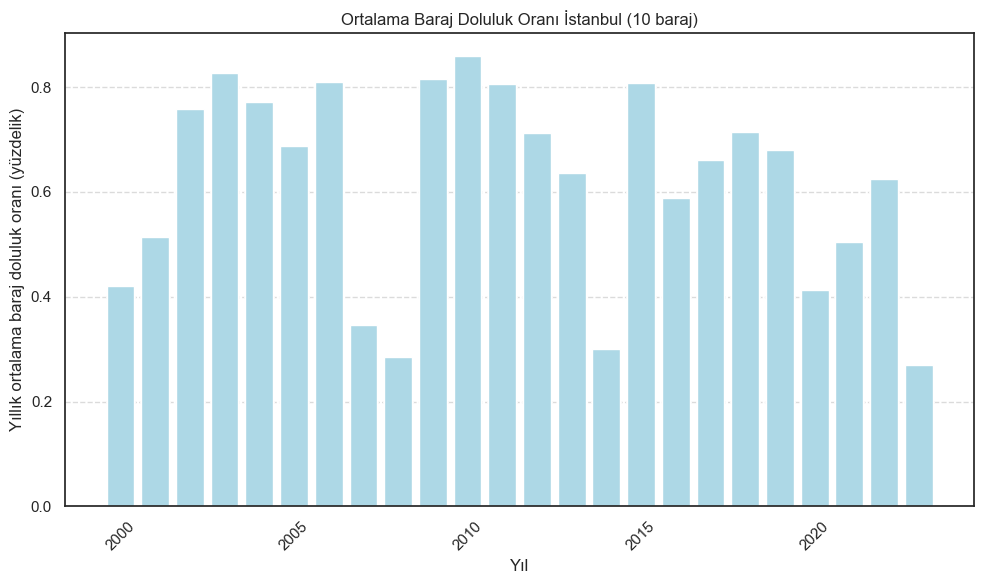

In [49]:
plt.figure(figsize=(10, 6))  # Grafik boyutunu belirleme
plt.bar(baraj_doluluk_istanbul["year"], baraj_doluluk_istanbul["yillik_ort"], color="lightblue")
plt.xlabel("Yıl")
plt.ylabel("Yıllık ortalama baraj doluluk oranı (yüzdelik)")
plt.title("Ortalama Baraj Doluluk Oranı İstanbul (10 baraj)")
plt.xticks(rotation=45)  # Eksen etiketlerini 45 derece döndürme
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y ekseni üzerinde ızgaralar ekler
plt.tight_layout()  # Grafik öğelerinin sığdırılması
plt.savefig('grafikler/12.png')

plt.show()

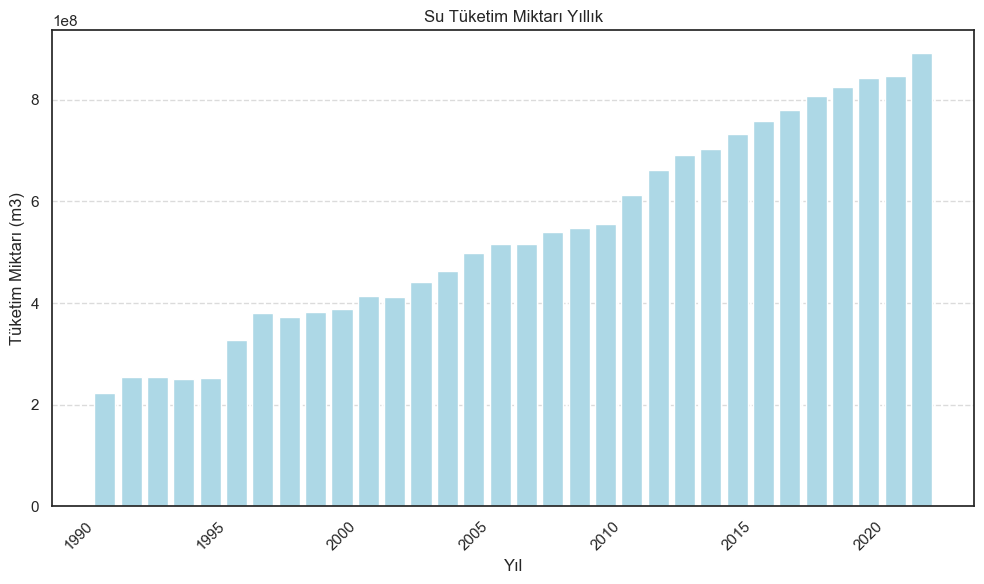

In [50]:
plt.figure(figsize=(10, 6))  # Grafik boyutunu belirleme
plt.bar(su_tuketim_m3["YIL"], su_tuketim_m3["TOPLAM M3"], color="lightblue")
plt.xlabel("Yıl")
plt.ylabel("Tüketim Miktarı (m3)")
plt.title("Su Tüketim Miktarı Yıllık")
plt.xticks(rotation=45)  # Eksen etiketlerini 45 derece döndürme
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y ekseni üzerinde ızgaralar ekler
plt.tight_layout()  # Grafik öğelerinin sığdırılması
plt.savefig('grafikler/13.png')

plt.show()

In [51]:
su_tuketim_yesil

,Yıl,Su Tüketimi (m3)
0,2017,13417588.0
1,2018,13769091.0
2,2019,16830146.0
3,2020,17542920.0
4,2021,15199415.0
5,2022,18825290.0


## Trafik ve Sıcaklık

In [52]:
topluulasim_saatlik_istanbul = pd.read_csv("toplu ulasim/istanbul_topluulasim_describe.csv")

In [53]:
trafik_saatlik_istanbul = pd.read_csv("trafik\istanbul_trafik_describe.csv")

In [54]:
topluulasim_saatlik_istanbul.loc[topluulasim_saatlik_istanbul["zaman"]=="aksam"]

,zaman,year,month,road_type,count,mean,std,min,25%,50%,75%,max
0,aksam,2020,1,DENİZ,10055.0,259.709498,539.814887,1.0,22.0,78.0,268.00,6072.0
1,aksam,2020,1,OTOYOL,225340.0,201.366429,1461.408967,1.0,16.0,55.0,168.00,82561.0
2,aksam,2020,1,RAYLI,5067.0,6094.401026,9345.317181,1.0,243.0,1650.0,7422.00,58757.0
3,aksam,2020,2,DENİZ,9383.0,279.218161,608.517968,1.0,22.0,81.0,277.00,7291.0
4,aksam,2020,2,OTOYOL,211621.0,215.376853,1525.028598,1.0,16.0,55.0,181.00,81433.0
...,...,...,...,...,...,...,...,...,...,...,...,...
124,aksam,2023,6,OTOYOL,211716.0,187.405156,1305.872610,1.0,15.0,51.0,156.00,75454.0
125,aksam,2023,6,RAYLI,6978.0,5036.330037,9132.932343,1.0,215.0,970.5,4666.75,65248.0
126,aksam,2023,7,DENİZ,14392.0,194.201779,316.094422,1.0,21.0,70.0,201.00,2698.0
127,aksam,2023,7,OTOYOL,213859.0,174.225868,1227.688990,1.0,15.0,48.0,147.00,69185.0


In [55]:
trafik_saatlik_istanbul["zaman"].value_counts()

aksam    43
gece     43
ogle     43
sabah    43
Name: zaman, dtype: int64

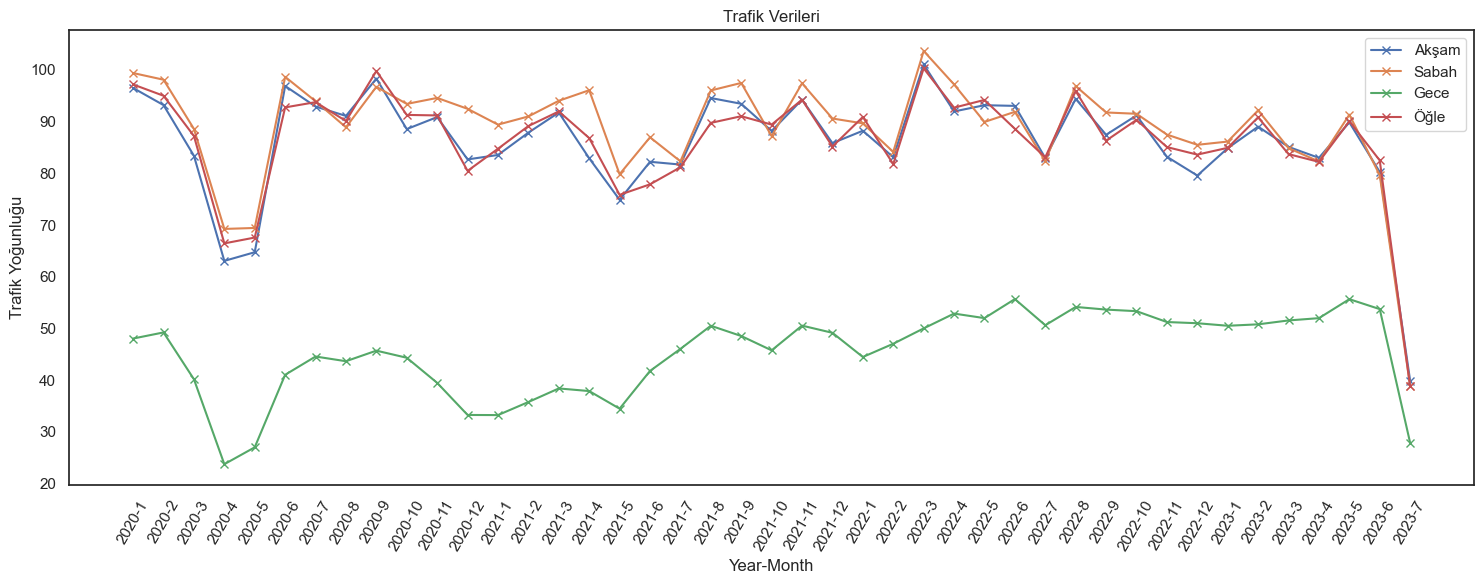

In [56]:
# 1. Verileri "aksam" zamanına göre filtreleyin ve "year" ve "month" sütunlarını seçin.
aksam = trafik_saatlik_istanbul.loc[trafik_saatlik_istanbul["zaman"] == "aksam"]
sabah = trafik_saatlik_istanbul.loc[trafik_saatlik_istanbul["zaman"] == "sabah"]
gece = trafik_saatlik_istanbul.loc[trafik_saatlik_istanbul["zaman"] == "gece"]
ogle = trafik_saatlik_istanbul.loc[trafik_saatlik_istanbul["zaman"] == "ogle"]

year_sutunu = aksam['year']
month_sutunu = aksam['month']

# 2. "year" ve "month" sütunlarını birleştirerek yeni bir "year-month" sütunu oluşturun.
year_month_sutunu = year_sutunu.astype(str) + "-" + month_sutunu.astype(str)

# 3. Bu yeni sütunu kullanarak çizgi grafiği çizin.
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(111)
lns1 = ax.plot(year_month_sutunu, aksam['mean'],label='Akşam', marker="x")  # 'your_istenen_sutun' yerine çizmek istediğiniz veriyi ekleyin
lns2 = ax.plot(year_month_sutunu, sabah['mean'],label='Sabah', marker="x")
lns3 = ax.plot(year_month_sutunu, gece['mean'],label='Gece', marker="x")
lns4 = ax.plot(year_month_sutunu, ogle['mean'],label='Öğle', marker="x")



plt.xlabel('Year-Month')
plt.ylabel('Trafik Yoğunluğu')  # Y ekseninin adını değiştirin
plt.title('Trafik Verileri')  # Grafiğin başlığını değiştirin
plt.xticks(rotation=60)  # x ekseni etiketlerini döndürmek için

# added these three lines
ax.legend()

plt.tight_layout()

plt.savefig('grafikler/13.png')
plt.show()

In [57]:
topluulasim_saatlik_istanbul

,zaman,year,month,road_type,count,mean,std,min,25%,50%,75%,max
0,aksam,2020,1,DENİZ,10055.0,259.709498,539.814887,1.0,22.0,78.0,268.0,6072.0
1,aksam,2020,1,OTOYOL,225340.0,201.366429,1461.408967,1.0,16.0,55.0,168.0,82561.0
2,aksam,2020,1,RAYLI,5067.0,6094.401026,9345.317181,1.0,243.0,1650.0,7422.0,58757.0
3,aksam,2020,2,DENİZ,9383.0,279.218161,608.517968,1.0,22.0,81.0,277.0,7291.0
4,aksam,2020,2,OTOYOL,211621.0,215.376853,1525.028598,1.0,16.0,55.0,181.0,81433.0
...,...,...,...,...,...,...,...,...,...,...,...,...
511,sabah,2023,6,OTOYOL,201544.0,162.709761,1032.266562,1.0,10.0,39.0,137.0,60652.0
512,sabah,2023,6,RAYLI,6711.0,3240.829683,6314.209663,1.0,99.0,549.0,2922.5,48310.0
513,sabah,2023,7,DENİZ,12939.0,104.839709,176.975963,1.0,10.0,34.0,117.0,1628.0
514,sabah,2023,7,OTOYOL,203800.0,156.956580,994.211562,1.0,10.0,38.0,133.0,54293.0


In [58]:
year_sutunu = topluulasim_saatlik_istanbul['year']
month_sutunu = topluulasim_saatlik_istanbul['month']

topluulasim_saatlik_istanbul["year_month"] = year_sutunu.astype(str) + "-" + month_sutunu.astype(str)


In [59]:
topluulasim_saatlik_istanbul

,zaman,year,month,road_type,count,mean,std,min,25%,50%,75%,max,year_month
0,aksam,2020,1,DENİZ,10055.0,259.709498,539.814887,1.0,22.0,78.0,268.0,6072.0,2020-1
1,aksam,2020,1,OTOYOL,225340.0,201.366429,1461.408967,1.0,16.0,55.0,168.0,82561.0,2020-1
2,aksam,2020,1,RAYLI,5067.0,6094.401026,9345.317181,1.0,243.0,1650.0,7422.0,58757.0,2020-1
3,aksam,2020,2,DENİZ,9383.0,279.218161,608.517968,1.0,22.0,81.0,277.0,7291.0,2020-2
4,aksam,2020,2,OTOYOL,211621.0,215.376853,1525.028598,1.0,16.0,55.0,181.0,81433.0,2020-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,sabah,2023,6,OTOYOL,201544.0,162.709761,1032.266562,1.0,10.0,39.0,137.0,60652.0,2023-6
512,sabah,2023,6,RAYLI,6711.0,3240.829683,6314.209663,1.0,99.0,549.0,2922.5,48310.0,2023-6
513,sabah,2023,7,DENİZ,12939.0,104.839709,176.975963,1.0,10.0,34.0,117.0,1628.0,2023-7
514,sabah,2023,7,OTOYOL,203800.0,156.956580,994.211562,1.0,10.0,38.0,133.0,54293.0,2023-7


In [60]:
topluulasim_saatlik_istanbul['total_mean'] = topluulasim_saatlik_istanbul.groupby(['zaman', 'year_month'])['mean'].transform('sum')


In [61]:
topluulasim_saatlik_istanbul.columns

Index(['zaman', 'year', 'month', 'road_type', 'count', 'mean', 'std', 'min',
       '25%', '50%', '75%', 'max', 'year_month', 'total_mean'],
      dtype='object')

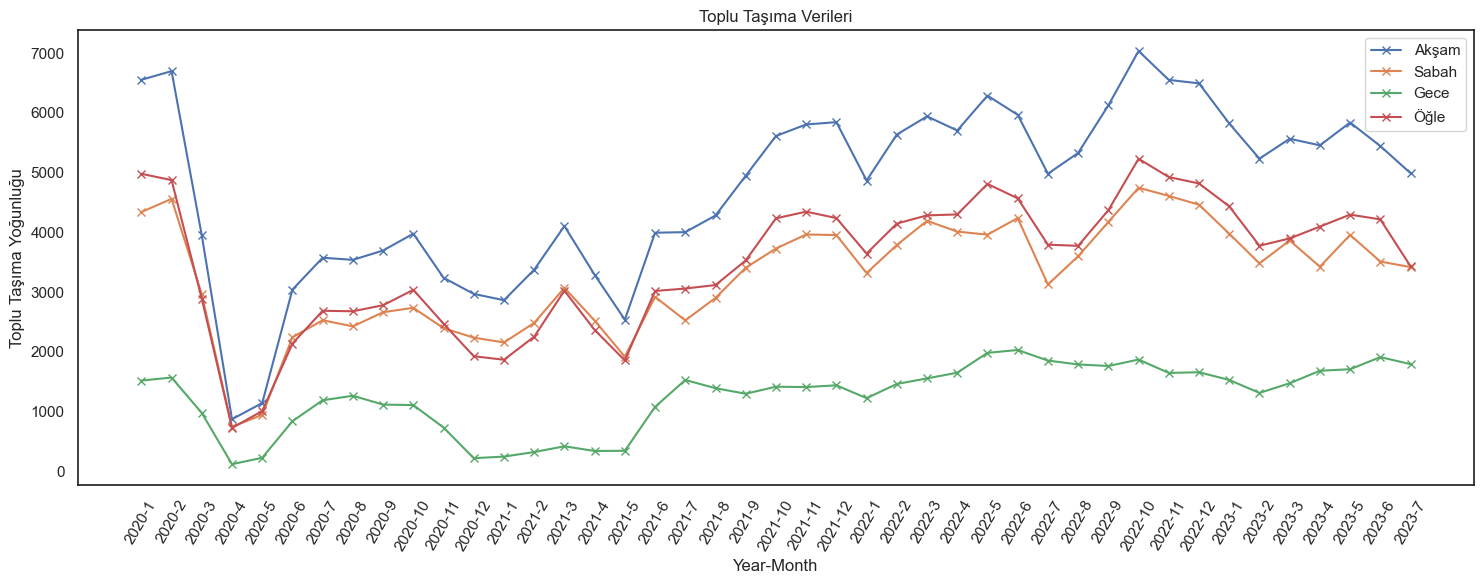

In [62]:
# 1. Verileri "aksam" zamanına göre filtreleyin ve "year" ve "month" sütunlarını seçin.
aksam = topluulasim_saatlik_istanbul.loc[topluulasim_saatlik_istanbul["zaman"] == "aksam"][["year_month","total_mean"]].drop_duplicates()
sabah = topluulasim_saatlik_istanbul.loc[topluulasim_saatlik_istanbul["zaman"] == "sabah"][["year_month","total_mean"]].drop_duplicates()
gece = topluulasim_saatlik_istanbul.loc[topluulasim_saatlik_istanbul["zaman"] == "gece"][["year_month","total_mean"]].drop_duplicates()
ogle = topluulasim_saatlik_istanbul.loc[topluulasim_saatlik_istanbul["zaman"] == "ogle"][["year_month","total_mean"]].drop_duplicates()



# 3. Bu yeni sütunu kullanarak çizgi grafiği çizin.
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(111)
ax.plot(aksam['year_month'], aksam['total_mean'],label='Akşam', marker="x")  # 'your_istenen_sutun' yerine çizmek istediğiniz veriyi ekleyin
ax.plot(sabah['year_month'], sabah['total_mean'],label='Sabah', marker="x")
ax.plot(gece['year_month'], gece['total_mean'],label='Gece', marker="x")
ax.plot(ogle['year_month'], ogle['total_mean'],label='Öğle', marker="x")



plt.xlabel('Year-Month')
plt.ylabel('Toplu Taşıma Yoğunluğu')  # Y ekseninin adını değiştirin
plt.title('Toplu Taşıma Verileri')  # Grafiğin başlığını değiştirin
plt.xticks(rotation=60)  # x ekseni etiketlerini döndürmek için

# added these three lines
ax.legend()

plt.tight_layout()

plt.savefig('grafikler/14.png')
plt.show()

In [63]:
topluulasim_saatlik_istanbul

,zaman,year,month,road_type,count,mean,std,min,25%,50%,75%,max,year_month,total_mean
0,aksam,2020,1,DENİZ,10055.0,259.709498,539.814887,1.0,22.0,78.0,268.0,6072.0,2020-1,6555.476953
1,aksam,2020,1,OTOYOL,225340.0,201.366429,1461.408967,1.0,16.0,55.0,168.0,82561.0,2020-1,6555.476953
2,aksam,2020,1,RAYLI,5067.0,6094.401026,9345.317181,1.0,243.0,1650.0,7422.0,58757.0,2020-1,6555.476953
3,aksam,2020,2,DENİZ,9383.0,279.218161,608.517968,1.0,22.0,81.0,277.0,7291.0,2020-2,6700.661899
4,aksam,2020,2,OTOYOL,211621.0,215.376853,1525.028598,1.0,16.0,55.0,181.0,81433.0,2020-2,6700.661899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,sabah,2023,6,OTOYOL,201544.0,162.709761,1032.266562,1.0,10.0,39.0,137.0,60652.0,2023-6,3510.040009
512,sabah,2023,6,RAYLI,6711.0,3240.829683,6314.209663,1.0,99.0,549.0,2922.5,48310.0,2023-6,3510.040009
513,sabah,2023,7,DENİZ,12939.0,104.839709,176.975963,1.0,10.0,34.0,117.0,1628.0,2023-7,3417.562146
514,sabah,2023,7,OTOYOL,203800.0,156.956580,994.211562,1.0,10.0,38.0,133.0,54293.0,2023-7,3417.562146


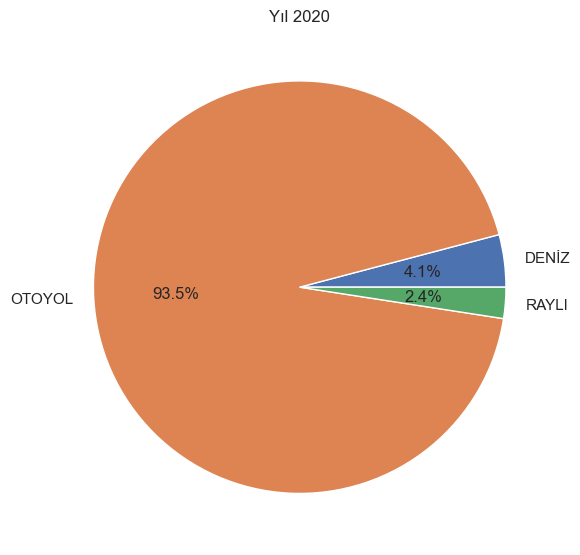

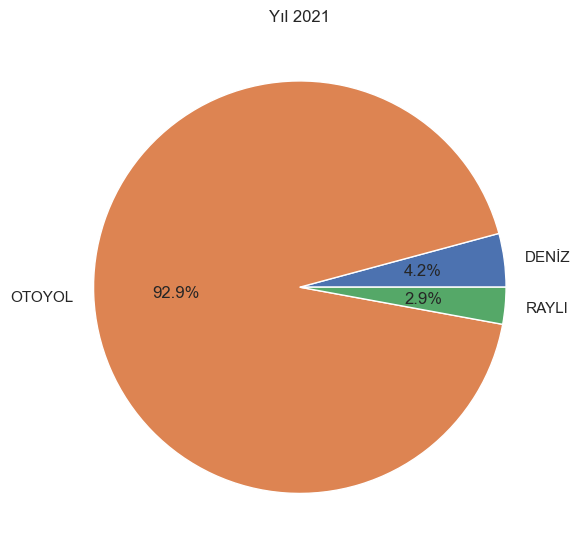

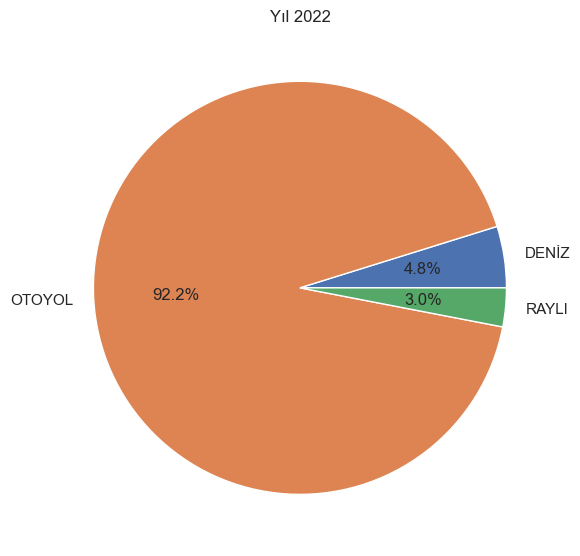

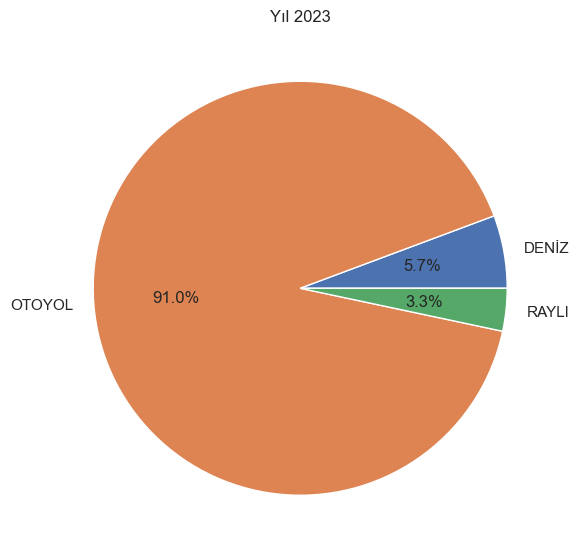

In [64]:
# Yıl ve road_type'a göre gruplayın ve toplam sayıları hesaplayın
grouped = topluulasim_saatlik_istanbul.groupby(['year', 'road_type'])['count'].sum().reset_index()

# Pie chart için verileri hazırlayın
years = grouped['year'].unique()
road_types = grouped['road_type'].unique()

for year in years:
    data_year = grouped[grouped['year'] == year]
    counts = data_year['count']
    road_type_labels = data_year['road_type']

    # Pie chart oluşturun
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=road_type_labels, autopct='%1.1f%%')
    plt.title(f'Yıl {year}')
    plt.tight_layout()
    plt.savefig(f'grafikler/15 {year}.png')
    plt.show()

# PREDICTION 

In [65]:
emisyon_owid_tur.rename(columns={"year": "date"}, inplace=True)

In [66]:
emisyon_owid_tur['month'] = emisyon_owid_tur['date'].dt.month
emisyon_owid_tur['year'] = emisyon_owid_tur['date'].dt.year

emisyon_owid_tur

,country,date,total_ghg,co2,methane,nitrous_oxide,month,year
46368,Turkey,1865-01-01,0.150,0.150,0.00,0.00,1,1865
46369,Turkey,1866-01-01,0.209,0.209,0.00,0.00,1,1866
46370,Turkey,1867-01-01,0.227,0.227,0.00,0.00,1,1867
46371,Turkey,1868-01-01,0.176,0.176,0.00,0.00,1,1868
46372,Turkey,1869-01-01,0.267,0.267,0.00,0.00,1,1869
...,...,...,...,...,...,...,...,...
46520,Turkey,2017-01-01,472.270,430.220,44.98,32.87,1,2017
46521,Turkey,2018-01-01,470.650,422.569,47.10,32.69,1,2018
46522,Turkey,2019-01-01,459.860,401.720,48.54,34.75,1,2019
46523,Turkey,2020-01-01,413.433,413.433,0.00,0.00,1,2020


In [67]:
emisyon_owid_tur[["year","month","total_ghg"]]

,year,month,total_ghg
46368,1865,1,0.150
46369,1866,1,0.209
46370,1867,1,0.227
46371,1868,1,0.176
46372,1869,1,0.267
...,...,...,...
46520,2017,1,472.270
46521,2018,1,470.650
46522,2019,1,459.860
46523,2020,1,413.433


In [68]:
emisyon_owid_tur[["year", "month"]]

,year,month
46368,1865,1
46369,1866,1
46370,1867,1
46371,1868,1
46372,1869,1
...,...,...
46520,2017,1
46521,2018,1
46522,2019,1
46523,2020,1


In [69]:
emisyon_owid_tur.reset_index(drop=True, inplace=True)

In [83]:
emisyon_owid_tur

,country,date,total_ghg,co2,methane,nitrous_oxide,month,year
0,Turkey,1865-01-01,0.150,0.150,0.00,0.00,1,1865
1,Turkey,1866-01-01,0.209,0.209,0.00,0.00,1,1866
2,Turkey,1867-01-01,0.227,0.227,0.00,0.00,1,1867
3,Turkey,1868-01-01,0.176,0.176,0.00,0.00,1,1868
4,Turkey,1869-01-01,0.267,0.267,0.00,0.00,1,1869
...,...,...,...,...,...,...,...,...
152,Turkey,2017-01-01,472.270,430.220,44.98,32.87,1,2017
153,Turkey,2018-01-01,470.650,422.569,47.10,32.69,1,2018
154,Turkey,2019-01-01,459.860,401.720,48.54,34.75,1,2019
155,Turkey,2020-01-01,413.433,413.433,0.00,0.00,1,2020


# EMİSYON ML

## SKLEARN

In [71]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC


# Verileri X (yıl ve ay) ve y (emisyon) olarak ayırma
X_linear_regression = emisyon_owid_tur[["year"]][115:]
y_linear_regression= emisyon_owid_tur["total_ghg"][115:].round()

X_xgboost = emisyon_owid_tur[["year"]][115:]
y_xgboost = emisyon_owid_tur["total_ghg"][115:].round()

X_catboost = emisyon_owid_tur[["year"]][115:]
y_catboost = emisyon_owid_tur["total_ghg"][115:].round()

X_random_forest = emisyon_owid_tur[["year"]][115:]
y_random_forest = emisyon_owid_tur["total_ghg"][115:].round()

X_svm = emisyon_owid_tur[["year"]][115:]
y_svm= emisyon_owid_tur["total_ghg"][115:].round()

# Lineer regresyon modelini oluşturma
linear_model = LinearRegression()
linear_model.fit(X_linear_regression, y_linear_regression)

svm = SVC(kernel="linear")
svm.fit(X_svm, y_svm)

# XGBoost modelini oluşturma
xgb_model = XGBRegressor()
xgb_model.fit(X_xgboost, y_xgboost)

# CatBoost modelini oluşturma
catboost_model = CatBoostRegressor(verbose=0)
catboost_model.fit(X_catboost, y_catboost)

# Random Forest modelini oluşturma
rf_model = RandomForestRegressor()
rf_model.fit(X_random_forest, y_random_forest)

predict_linear_regression = pd.DataFrame()
predict_xgboost = pd.DataFrame()
predict_catboost = pd.DataFrame()
predict_random_forest = pd.DataFrame()
predict_svm = pd.DataFrame()

predict = pd.DataFrame()
predict["year"] = list(range(2022, 2051))

predicted_linear_regression = pd.DataFrame(columns=["year", "value"])
predicted_xgboost = pd.DataFrame(columns=["year", "value"])
predicted_catboost = pd.DataFrame(columns=["year", "value"])
predicted_random_forest = pd.DataFrame(columns=["year", "value"])
predicted_svm = pd.DataFrame(columns=["year", "value"])


warnings.filterwarnings("ignore", message="X does not have valid feature names, but LinearRegression was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but RandomForestRegressor was fitted with feature names")

for year in predict["year"]:
    

    # Modellerin tahminlerini yapma
    predict_linear_regression = linear_model.predict(np.array([[year]]))
    predict_xgboost = xgb_model.predict(np.array([[year]]))
    predict_catboost = catboost_model.predict(np.array([[year]]))
    predict_random_forest = rf_model.predict(np.array([[year]]))
    predict_svm = rf_model.predict(np.array([[year]]))
    print(str(np.array([[year]])[0][0]) + ' has predicted. ✔️')
    
    
    # Append predictions to the DataFrames
    predicted_linear_regression = predicted_linear_regression.append({"year": year, "value": predict_linear_regression[-1]}, ignore_index=True)
    predicted_linear_regression["year"] = predicted_linear_regression["year"].round().astype("int")
    predicted_linear_regression["value"] = predicted_linear_regression["value"].round().astype("int")
    predicted_xgboost = predicted_xgboost.append({"year": year, "value": predict_xgboost[-1]}, ignore_index=True)
    predicted_xgboost["year"] = predicted_xgboost["year"].round().astype("int")
    predicted_xgboost["value"] = predicted_xgboost["value"].round().astype("int")
    predicted_catboost = predicted_catboost.append({"year": year, "value": predict_catboost[-1]}, ignore_index=True)
    predicted_catboost["year"] = predicted_catboost["year"].round().astype("int")
    predicted_catboost["value"] = predicted_catboost["value"].round().astype("int")
    predicted_random_forest = predicted_random_forest.append({"year": year, "value": predict_random_forest[-1]}, ignore_index=True)
    predicted_random_forest["year"] = predicted_random_forest["year"].round().astype("int")
    predicted_random_forest["value"] = predicted_random_forest["value"].round().astype("int")
    predicted_svm = predicted_svm.append({"year": year, "value": predict_svm[-1]}, ignore_index=True)
    predicted_svm["year"] = predicted_svm["year"].round().astype("int")
    predicted_svm["value"] = predicted_svm["value"].round().astype("int")
    

    X_linear_regression = pd.concat([X_linear_regression, predicted_linear_regression[["year"]][-1:]], ignore_index=True)
    y_linear_regression = pd.concat([y_linear_regression, predicted_linear_regression["value"][-1:]], ignore_index=True)
    X_xgboost = pd.concat([X_xgboost, predicted_xgboost[["year"]][-1:]], ignore_index=True)
    y_xgboost = pd.concat([y_xgboost, predicted_xgboost["value"][-1:]], ignore_index=True)
    X_catboost = pd.concat([X_catboost, predicted_catboost[["year"]][-1:]], ignore_index=True)
    y_catboost = pd.concat([y_catboost, predicted_catboost["value"][-1:]], ignore_index=True)
    X_random_forest = pd.concat([X_random_forest, predicted_random_forest[["year"]][-1:]], ignore_index=True)
    y_random_forest = pd.concat([y_random_forest, predicted_random_forest["value"][-1:]], ignore_index=True)
    X_svm = pd.concat([X_svm, predicted_svm[["year"]][-1:]], ignore_index=True)
    y_svm = pd.concat([y_svm, predicted_svm["value"][-1:]], ignore_index=True)
    
    linear_model.fit(X_linear_regression, y_linear_regression)
    xgb_model.fit(X_xgboost, y_xgboost)
    catboost_model.fit(X_catboost, y_catboost)
    rf_model.fit(X_random_forest, y_random_forest)
    svm.fit(X_svm, y_svm)

predicted_emission = pd.DataFrame()
predicted_emission["year"] = predicted_linear_regression["year"]
predicted_emission["xgb_value"] = predicted_xgboost["value"]
predicted_emission["lregression_value"] = predicted_linear_regression["value"]
predicted_emission["cat_value"] = predicted_catboost["value"]
predicted_emission["rf_value"] = predicted_random_forest["value"]
predicted_emission["svm"] = predicted_svm["value"]

predicted_emission

2022 has predicted. ✔️
2023 has predicted. ✔️
2024 has predicted. ✔️
2025 has predicted. ✔️
2026 has predicted. ✔️
2027 has predicted. ✔️
2028 has predicted. ✔️
2029 has predicted. ✔️
2030 has predicted. ✔️
2031 has predicted. ✔️
2032 has predicted. ✔️
2033 has predicted. ✔️
2034 has predicted. ✔️
2035 has predicted. ✔️
2036 has predicted. ✔️
2037 has predicted. ✔️
2038 has predicted. ✔️
2039 has predicted. ✔️
2040 has predicted. ✔️
2041 has predicted. ✔️
2042 has predicted. ✔️
2043 has predicted. ✔️
2044 has predicted. ✔️
2045 has predicted. ✔️
2046 has predicted. ✔️
2047 has predicted. ✔️
2048 has predicted. ✔️
2049 has predicted. ✔️
2050 has predicted. ✔️


,year,xgb_value,lregression_value,cat_value,rf_value,svm
0,2022,446,452,445,442,442
1,2023,446,461,444,441,441
2,2024,446,470,443,442,442
3,2025,446,480,442,442,442
4,2026,446,489,441,442,442
5,2027,446,498,440,442,442
6,2028,446,507,439,442,442
7,2029,446,516,438,442,442
8,2030,446,526,437,442,442
9,2031,446,535,436,442,442


# SICAKLIK ML

## SKLEARN

In [72]:
sicaklik = pd.DataFrame()
sicaklik["time"] = istanbul_ortalama["time"]
sicaklik["sicaklik"] = ten_year_avg
sicaklik = sicaklik[:-2]
sicaklik["year"] = sicaklik["time"].dt.year
emisyon = emisyon_owid_tur[["year", "total_ghg"]]
predicted_emission_final = predicted_emission[["year","lregression_value"]].rename(columns={"lregression_value":"total_ghg"})
sicaklik = pd.merge(sicaklik, emisyon, on='year')
sicaklik = sicaklik[9:][["sicaklik","year","total_ghg"]]
sicaklik["total_ghg"] = sicaklik["total_ghg"].round()
sicaklik

,sicaklik,year,total_ghg
9,14.440417,1938,5.0
10,14.525833,1939,5.0
11,14.405417,1940,5.0
12,14.350417,1941,6.0
13,14.155000,1942,5.0
...,...,...,...
88,15.821405,2017,472.0
89,15.928299,2018,471.0
90,16.007465,2019,460.0
91,15.984965,2020,413.0


In [73]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC


# Verileri X (yıl ve ay) ve y (emisyon) olarak ayırma
X_linear_regression = sicaklik[["year","total_ghg"]][42:]
y_linear_regression= sicaklik["sicaklik"][42:]

# Lineer regresyon modelini oluşturma
linear_model = LinearRegression()
linear_model.fit(X_linear_regression, y_linear_regression)

predict_linear_regression = pd.DataFrame()

predict = pd.DataFrame()
predict["year"] = list(range(2022, 2051))
predict = pd.merge(predict, predicted_emission_final, on='year')
predict

predicted_linear_regression = pd.DataFrame(columns=["year", "value"])


warnings.filterwarnings("ignore", message="X does not have valid feature names, but LinearRegression was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but RandomForestRegressor was fitted with feature names")

for index,row in predict.iterrows():
    
    year = row["year"]
    total_ghg = row["total_ghg"]

    # Modellerin tahminlerini yapma
    predict_linear_regression = linear_model.predict(np.array([[year,total_ghg]]))
    print(str(np.array([[year]])[0][0]) + ' has predicted. ✔️')
    
    
    # Append predictions to the DataFrames
    predicted_linear_regression = predicted_linear_regression.append({"year": year, "total_ghg": total_ghg, "value": predict_linear_regression[-1]}, ignore_index=True)
    predicted_linear_regression["year"] = predicted_linear_regression["year"].round().astype("int")
    predicted_linear_regression["total_ghg"] = predicted_linear_regression["total_ghg"].round().astype("int")

    X_linear_regression = pd.concat([X_linear_regression, predicted_linear_regression[["year","total_ghg"]][-1:]], ignore_index=True)
    y_linear_regression = pd.concat([y_linear_regression, predicted_linear_regression["value"][-1:]], ignore_index=True)
    
    linear_model.fit(X_linear_regression, y_linear_regression)

predicted_sicaklik = pd.DataFrame()
predicted_sicaklik["year"] = predicted_linear_regression["year"]
predicted_sicaklik["total_ghg"] = predicted_linear_regression["total_ghg"]
predicted_sicaklik["sicaklik"] = predicted_linear_regression["value"]

predicted_sicaklik

2022 has predicted. ✔️
2023 has predicted. ✔️
2024 has predicted. ✔️
2025 has predicted. ✔️
2026 has predicted. ✔️
2027 has predicted. ✔️
2028 has predicted. ✔️
2029 has predicted. ✔️
2030 has predicted. ✔️
2031 has predicted. ✔️
2032 has predicted. ✔️
2033 has predicted. ✔️
2034 has predicted. ✔️
2035 has predicted. ✔️
2036 has predicted. ✔️
2037 has predicted. ✔️
2038 has predicted. ✔️
2039 has predicted. ✔️
2040 has predicted. ✔️
2041 has predicted. ✔️
2042 has predicted. ✔️
2043 has predicted. ✔️
2044 has predicted. ✔️
2045 has predicted. ✔️
2046 has predicted. ✔️
2047 has predicted. ✔️
2048 has predicted. ✔️
2049 has predicted. ✔️
2050 has predicted. ✔️


,year,total_ghg,sicaklik
0,2022,452,15.880889
1,2023,461,15.933847
2,2024,470,15.986804
3,2025,480,16.041160
4,2026,489,16.094118
5,2027,498,16.147075
6,2028,507,16.200033
7,2029,516,16.252990
8,2030,526,16.307346
9,2031,535,16.360304


# ML GRAFİK

In [74]:
sicaklik["sicaklik"]

9     14.440417
10    14.525833
11    14.405417
12    14.350417
13    14.155000
        ...    
88    15.821405
89    15.928299
90    16.007465
91    15.984965
92    15.964965
Name: sicaklik, Length: 84, dtype: float64

In [75]:
predicted_sicaklik['sicaklik']

0     15.880889
1     15.933847
2     15.986804
3     16.041160
4     16.094118
5     16.147075
6     16.200033
7     16.252990
8     16.307346
9     16.360304
10    16.413261
11    16.466219
12    16.520575
13    16.573532
14    16.626490
15    16.679447
16    16.732405
17    16.786761
18    16.839718
19    16.892676
20    16.945633
21    16.998591
22    17.052947
23    17.105905
24    17.158862
25    17.211819
26    17.266176
27    17.319133
28    17.372091
Name: sicaklik, dtype: float64

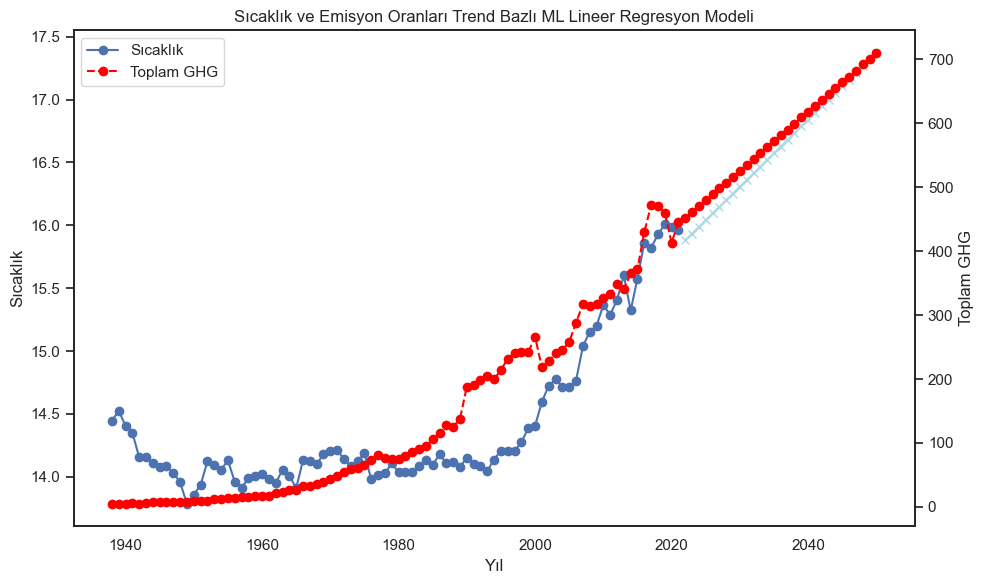

In [76]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)
lns1 = ax.plot(sicaklik['year'], sicaklik['sicaklik'], label='Sıcaklık', marker='o')
lns3 = ax.plot(predicted_sicaklik['year'], predicted_sicaklik['sicaklik'], label='Toplam GHG', color='lightblue', marker='x')

ax2 = ax.twinx()
lns2 = ax2.plot(sicaklik['year'], sicaklik['total_ghg'], label='Toplam GHG', linestyle="--" ,color='red', marker='o')
lns4 = ax2.plot(predicted_sicaklik['year'], predicted_sicaklik['total_ghg'], linestyle="--", label='Toplam GHG', color='red', marker='o')

#ax4 = ax.twinx()
#lns4 = ax2.plot(predicted_sicaklik['year'], predicted_sicaklik['total_ghg'], label='Toplam GHG', color='red', marker='o')

# Eksenleri etiketleyin ve başlığı ekleyin
plt.title('Sıcaklık ve Emisyon Oranları Trend Bazlı ML Lineer Regresyon Modeli')
ax.set_xlabel('Yıl')
ax.set_ylabel('Sıcaklık')
ax2.set_ylabel('Toplam GHG')

# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

plt.tight_layout()
plt.savefig('grafikler/16.png')
# Grafiği göster
plt.show()

## FINAL DATA SAVINGSemisyon_tuik

In [77]:
emisyon_tuik

,Yıl,Toplam,CO2,CH4,N2O,FGAZ,year,total_ghg
0,1990-01-01,219.526151,151.614981,42.487543,24.950823,0.472804,1990,219.526151
1,1991-01-01,226.794721,158.126315,43.377429,24.733992,0.556985,1991,226.794721
2,1992-01-01,233.132483,164.064876,43.288202,25.25965,0.519754,1992,233.132483
3,1993-01-01,240.771746,171.138875,43.06554,26.048287,0.519045,1993,240.771746
4,1994-01-01,234.38783,167.565647,42.787878,23.570421,0.463884,1994,234.38783
5,1995-01-01,248.248909,181.355257,42.613471,23.870854,0.409326,1995,248.248909
6,1996-01-01,267.581386,199.646693,42.968946,24.54246,0.423287,1996,267.581386
7,1997-01-01,278.813841,212.108198,42.231314,24.050525,0.423804,1997,278.813841
8,1998-01-01,280.318959,212.135043,42.421875,25.338883,0.423158,1998,280.318959
9,1999-01-01,277.776799,207.927912,43.789483,25.636443,0.422961,1999,277.776799


In [78]:
import pandas as pd

# Assuming istanbul_ortalama is your DataFrame
istanbul_ortalama["time"] = pd.to_datetime(istanbul_ortalama["time"], format='%Y-%m-%d')
istanbul_ortalama["time"] = istanbul_ortalama["time"].apply(lambda x: x.replace(day=1, month=1))
filtered_df = istanbul_ortalama[(istanbul_ortalama["time"].dt.year >= 1938) & (istanbul_ortalama["time"].dt.year <= 2021)]
filtered_df.rename(columns={"time":"Tarih"}, inplace=True)

c:\users\emrecan.ulu.desktop-4t87dph\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [79]:
filtered_df

,Tarih,tavg
9,1938-01-01,14.262500
10,1939-01-01,14.675000
11,1940-01-01,13.516667
12,1941-01-01,13.720833
13,1942-01-01,13.045833
...,...,...
88,2017-01-01,15.925000
89,2018-01-01,17.127273
90,2019-01-01,16.766667
91,2020-01-01,16.266667


In [80]:
emisyon_tuik["Tarih"] = pd.to_datetime(emisyon_tuik["Yıl"], format='%d.%m.%Y')
sicaklik['Tarih'] = pd.to_datetime('01.01.' + sicaklik['year'].astype(str), format='%d.%m.%Y')
predicted_sicaklik['Tarih'] = pd.to_datetime('01.01.' + predicted_sicaklik['year'].astype(str), format='%d.%m.%Y')
dikilen_agac_istanbul['Tarih'] = pd.to_datetime('01.01.' + dikilen_agac_istanbul['Year'].astype(str), format='%d.%m.%Y')
bakim_agac_istanbul['Tarih'] = pd.to_datetime('01.01.' + bakim_agac_istanbul['Year'].astype(str), format='%d.%m.%Y')
sicaklik = pd.merge(sicaklik,filtered_df,on="Tarih")

In [99]:
emisyon_tuik.to_csv(r"BItooldata/emisyon_tuik.csv")
sicaklik.to_csv(r"BItooldata/sicaklik_emisyon_reel.csv")
predicted_sicaklik.to_csv(r"BItooldata/sicaklik_emisyon_predicted.csv")
dikilen_agac_istanbul.to_csv(r"BItooldata/bakim_agac_istanbul.csv")
bakim_agac_istanbul.to_csv(r"BItooldata/dikilen_agac_istanbul.csv")
melted_emisyon_tuik = pd.melt(emisyon_tuik, id_vars=['Yıl', 'year', 'total_ghg', 'Tarih'], 
                               var_name='Gas', value_name='Emission')
melted_emisyon_owid_tur = pd.melt(emisyon_owid_tur.drop(columns="month")[73:], id_vars=["country","date","year"],
                                 var_name="Gas", value_name="Emission")
melted_emisyon_tuik.to_csv(r"BItooldata/melted_emisyon_tuik.csv", index=False)
melted_emisyon_owid_tur.to_csv(r"BItooldata/melted_emisyon_owid_tur.csv", index=False)



In [102]:
melted_emisyon_owid_tur

,country,date,year,Gas,Emission
0,Turkey,1938-01-01,1938,total_ghg,4.634
1,Turkey,1939-01-01,1939,total_ghg,4.905
2,Turkey,1940-01-01,1940,total_ghg,5.469
3,Turkey,1941-01-01,1941,total_ghg,5.619
4,Turkey,1942-01-01,1942,total_ghg,4.946
...,...,...,...,...,...
331,Turkey,2017-01-01,2017,nitrous_oxide,32.870
332,Turkey,2018-01-01,2018,nitrous_oxide,32.690
333,Turkey,2019-01-01,2019,nitrous_oxide,34.750
334,Turkey,2020-01-01,2020,nitrous_oxide,0.000


In [92]:
melted_emisyon_tuik

,Yıl,year,total_ghg,Tarih,Gas,Emission
0,1990-01-01,1990,219.526151,1990-01-01,Toplam,219.526151
1,1991-01-01,1991,226.794721,1991-01-01,Toplam,226.794721
2,1992-01-01,1992,233.132483,1992-01-01,Toplam,233.132483
3,1993-01-01,1993,240.771746,1993-01-01,Toplam,240.771746
4,1994-01-01,1994,234.38783,1994-01-01,Toplam,234.38783
...,...,...,...,...,...,...
155,2017-01-01,2017,528.565929,2017-01-01,FGAZ,5.404404
156,2018-01-01,2018,523.108034,2018-01-01,FGAZ,5.184738
157,2019-01-01,2019,508.725873,2019-01-01,FGAZ,5.84972
158,2020-01-01,2020,523.990817,2020-01-01,FGAZ,6.679617


,country,date,total_ghg,co2,methane,nitrous_oxide,month,year
73,Turkey,1938-01-01,4.634,4.634,0.00,0.00,1,1938
74,Turkey,1939-01-01,4.905,4.905,0.00,0.00,1,1939
75,Turkey,1940-01-01,5.469,5.469,0.00,0.00,1,1940
76,Turkey,1941-01-01,5.619,5.619,0.00,0.00,1,1941
77,Turkey,1942-01-01,4.946,4.946,0.00,0.00,1,1942
...,...,...,...,...,...,...,...,...
152,Turkey,2017-01-01,472.270,430.220,44.98,32.87,1,2017
153,Turkey,2018-01-01,470.650,422.569,47.10,32.69,1,2018
154,Turkey,2019-01-01,459.860,401.720,48.54,34.75,1,2019
155,Turkey,2020-01-01,413.433,413.433,0.00,0.00,1,2020
